# MRI maps

Goal: Correlate gradients with HCP maps from Jakob

In [1]:
# Import modules and R
import numpy as np, pandas as pd
from plotnine import *
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
from gradientVersion import *
from pcaVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/plot_maps.R");

/opt/conda/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.


Get maps

In [3]:
maps = get_maps()

Get gradients

In [4]:
dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds9')
scores = dm_hcp_ds9.clean_scores()

New gradients version: method=dm, kernel=normalized_angle, data=hcp_ds9


In [145]:
pca_hcp_3d_ds8 = gradientVersion(approach='pca').fit('hcp_3donors_ds8')
scores = pca_hcp_3d_ds8.clean_scores(flips=[])

New gradients version: method=pca, kernel=None, data=hcp_3donors_ds8


In [162]:
pca_hcp_ds8 = pcaVersion('hcp_ds8')
pca_hcp_3d_ds8 = pcaVersion('hcp_3donors_ds8')
scores = pca_hcp_ds8.score_from(pca_hcp_3d_ds8).iloc[:,:3].rename_axis('id').join(get_labels_hcp())

New PCA version
New PCA version


In [62]:
corrs = get_corrs(scores, maps, method='pearson')
corrs.style.format('{:.2f}')

In [63]:
sim_grads = np.load("../outputs/permutations/sim_gradients_1000.npy")
null_corrs = corr_nulls_from_grads(sim_grads, scores, maps, method='pearson')
null_p = get_null_p(corrs, null_corrs, adjust='fdr_bh')

In [91]:
maps_to_plot = ['Cortical Thickness', 'Glycolytic Index (CMRO2/CMRGlu)']
maps_scatter = maps.loc[:,maps_to_plot].join(scores.set_index('label')).reset_index()
maps_scatter_corrs = null_p.query("map in @maps_to_plot & G in ['G1','G2']").loc[:,['map','G','true_mean','q']]
maps_to_plot = maps.loc[:,maps_to_plot]

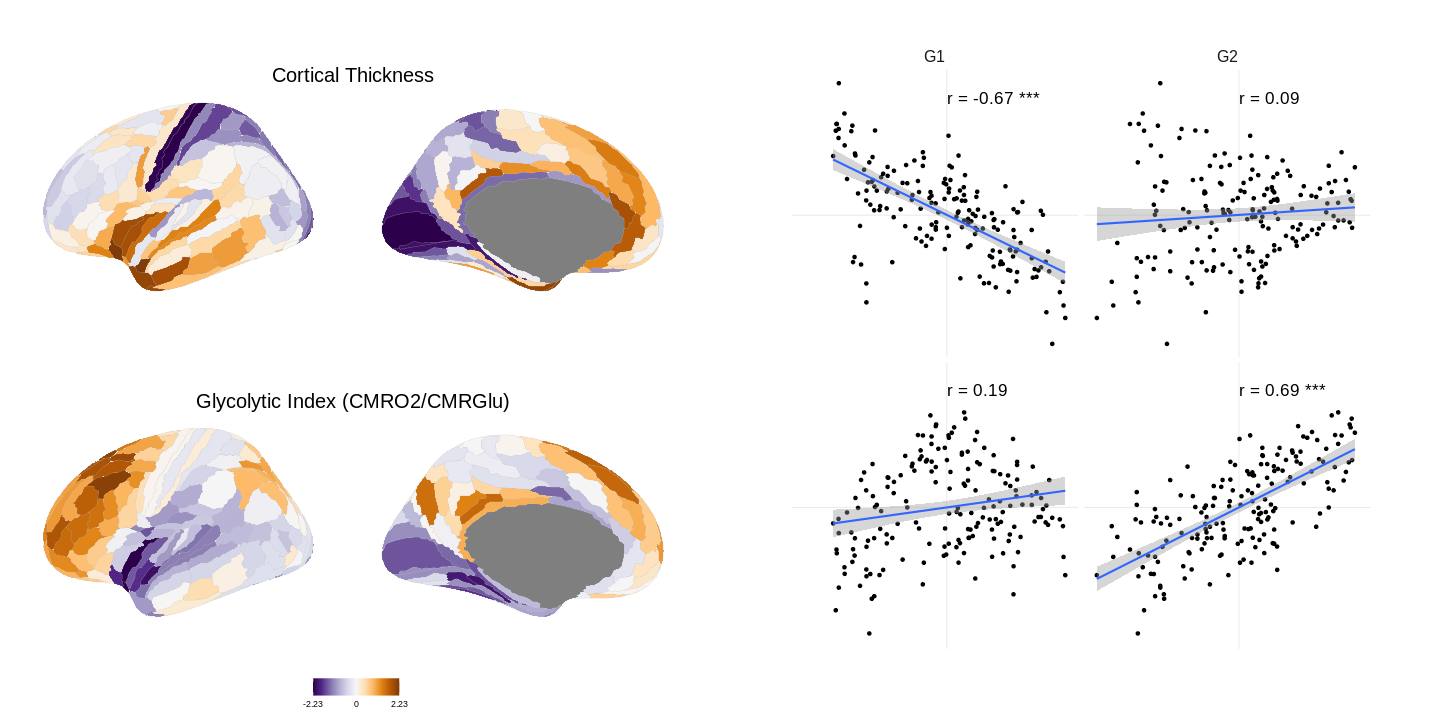

In [102]:
%%R -i maps_scatter -i maps_scatter_corrs -i maps_to_plot -w 20 -h 10 --units in
source("../code/plot_maps.R")

g1 <- plot_maps(maps_to_plot, ncol=1, colors=rev(brewer.puor(100)), spacing=6) 
g2 <- plot_maps_scatter(maps_scatter, maps_scatter_corrs)

g1 | g2

In [97]:
# Match distance matrix to gradient parcels to simulate maps
dist_mat = np.loadtxt("../data/LeftParcelGeodesicDistmat.txt")
inds = [i-1 for i in scores.index]
dist_mat_matched = dist_mat[inds,:][:,inds]
np.savetxt("../data/LeftParcelGeodesicDistmat_matched_3donors.txt", dist_mat_matched)

In [27]:
generate_spins(maps, n=1000, outfile="../outputs/permutations/spin_maps_1000.npy", atlas='hcp')
# generate_spins_from_gradients(scores, n=1000, outfile='../outputs/permutations/spin_gradients_pca_1000.npy', atlas='hcp')
# generate_spins_from_gradients(scores, n=1000, outfile='../outputs/permutations/spin_gradients_pca_proj_1000.npy', atlas='hcp')

generate_simulations(maps, n=1000, outfile='../outputs/permutations/sim_maps_1000.npy', atlas='hcp')
# generate_simulations(scores, n=1000, outfile='../outputs/permutations/sim_gradients_pca_1000.npy',
#                     dist_mat = "../data/LeftParcelGeodesicDistmat_matched.txt")
# generate_simulations(scores, n=1000, outfile='../outputs/permutations/sim_gradients_pca_proj_1000.npy',
                    # dist_mat = "../data/LeftParcelGeodesicDistmat_matched.txt")

In [151]:
spin_maps = np.load("../outputs/permutations/spin_maps_1000.npy")
# spin_grads = np.load("../outputs/permutations/spin_gradients_1000.npy")
# spin_grads = np.load("../outputs/permutations/spin_gradients_pca_1000.npy")
spin_grads = np.load("../outputs/permutations/spin_gradients_pca_proj_1000.npy")
sim_maps = np.load("../outputs/permutations/sim_maps_1000.npy")
# sim_grads = np.load("../outputs/permutations/sim_gradients_1000.npy")
# sim_grads = np.load("../outputs/permutations/sim_gradients_pca_1000.npy")
sim_grads = np.load("../outputs/permutations/sim_gradients_pca_proj_1000.npy")

Pearson correlation versions

In [152]:
null_corrs_dict = {}
null_corrs_dict['spin_maps_p'] = corr_nulls_from_maps(spin_maps, scores, maps, method='pearson')
null_corrs_dict['spin_maps_p_pool'] = corr_nulls_from_maps(spin_maps, scores, maps, method='pearson', pool=True)
null_corrs_dict['spin_grads_p'] = corr_nulls_from_grads(spin_grads, scores, maps, method='pearson')
null_corrs_dict['spin_grads_p_pool'] = corr_nulls_from_grads(spin_grads, scores, maps, method='pearson', pool=True, pool_frac=1)

null_corrs_dict['sim_maps_p'] = corr_nulls_from_maps(sim_maps, scores, maps, method='pearson')
null_corrs_dict['sim_maps_p_pool'] = corr_nulls_from_maps(sim_maps, scores, maps, method='pearson', pool=True)
null_corrs_dict['sim_grads_p'] = corr_nulls_from_grads(sim_grads, scores, maps, method='pearson')
null_corrs_dict['sim_grads_p_pool'] = corr_nulls_from_grads(sim_grads, scores, maps, method='pearson', pool=True, pool_frac=1)

Spearman correlation versions

In [ ]:
# null_corrs_dict['spin_maps_s'] = corr_nulls_from_maps(spin_maps, scores, maps, method='spearman')
# null_corrs_dict['spin_maps_s_pool'] = corr_nulls_from_maps(spin_maps, scores, maps, method='spearman', pool=True)
# null_corrs_dict['spin_grads_s'] = corr_nulls_from_grads(spin_grads, scores, maps, method='spearman')
# null_corrs_dict['spin_grads_s_pool'] = corr_nulls_from_grads(spin_grads, scores, maps, method='spearman', pool=True)
# save_pickle(null_corrs_dict, 'null_corrs_dict')

# null_corrs_dict['sim_maps_s'] = corr_nulls_from_maps(sim_maps, scores, maps, method='spearman')
# null_corrs_dict['sim_maps_s_pool'] = corr_nulls_from_maps(sim_maps, scores, maps, method='spearman', pool=True)
# null_corrs_dict['sim_grads_s'] = corr_nulls_from_grads(sim_grads, scores, maps, method='spearman')
# null_corrs_dict['sim_grads_s_pool'] = corr_nulls_from_grads(sim_grads, scores, maps, method='spearman', pool=True)    
# save_pickle(null_corrs_dict, 'null_corrs_dict')

In [153]:
# save_pickle(null_corrs_dict, 'null_corrs_dict')
# save_pickle(null_corrs_dict, 'null_corrs_dict_pca')
save_pickle(null_corrs_dict, 'null_corrs_dict_pca_proj')
# null_corrs_dict = load_pickle('null_corrs_dict')

In [164]:
corrs = get_corrs(scores, maps, atlas='hcp')
corr_versions = {version:get_null_p(corrs, null_corrs, adjust='fdr_bh') 
                 for version, null_corrs in null_corrs_dict.items()}
corr_versions = pd.concat(corr_versions).reset_index(0).rename({'level_0':'version'},axis=1)

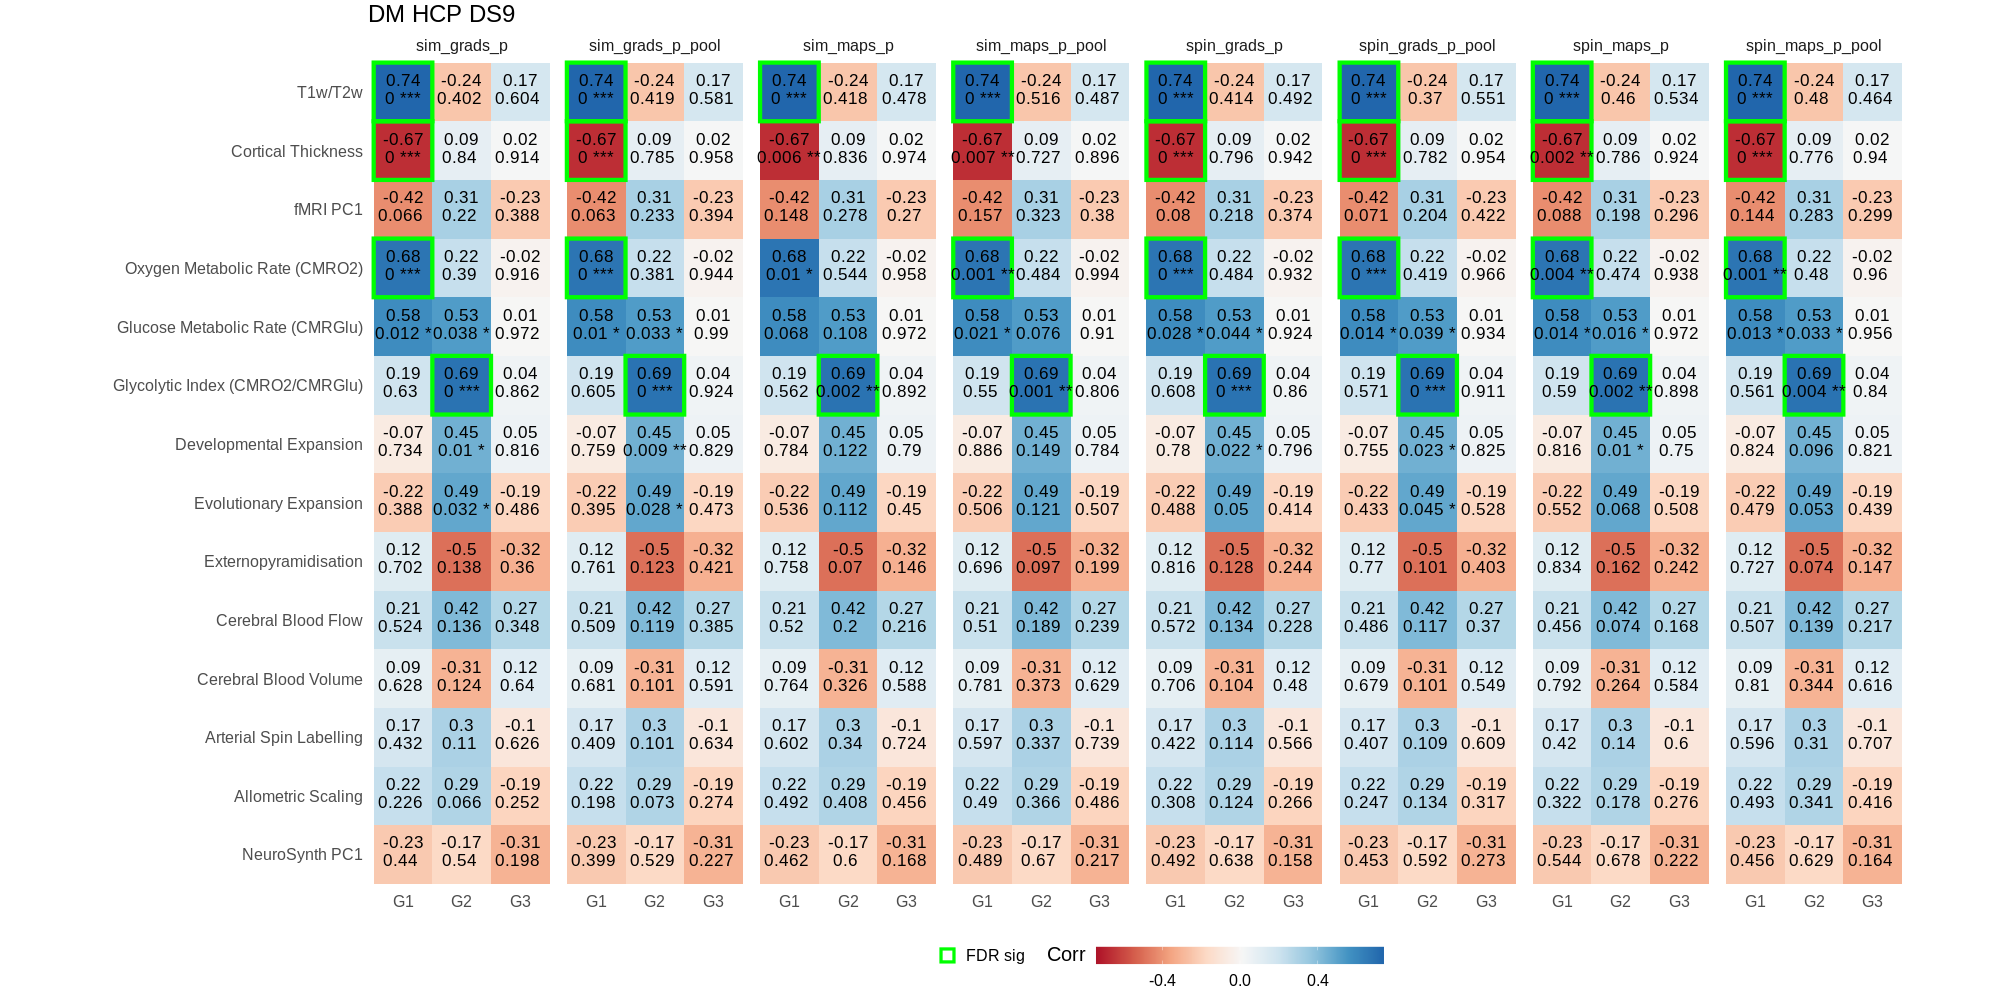

In [142]:
%%R -i corr_versions -w 2000 -h 1000
source("../code/plot_maps.R")
plot_corr_versions(corr_versions) + ggtitle('DM HCP DS9')

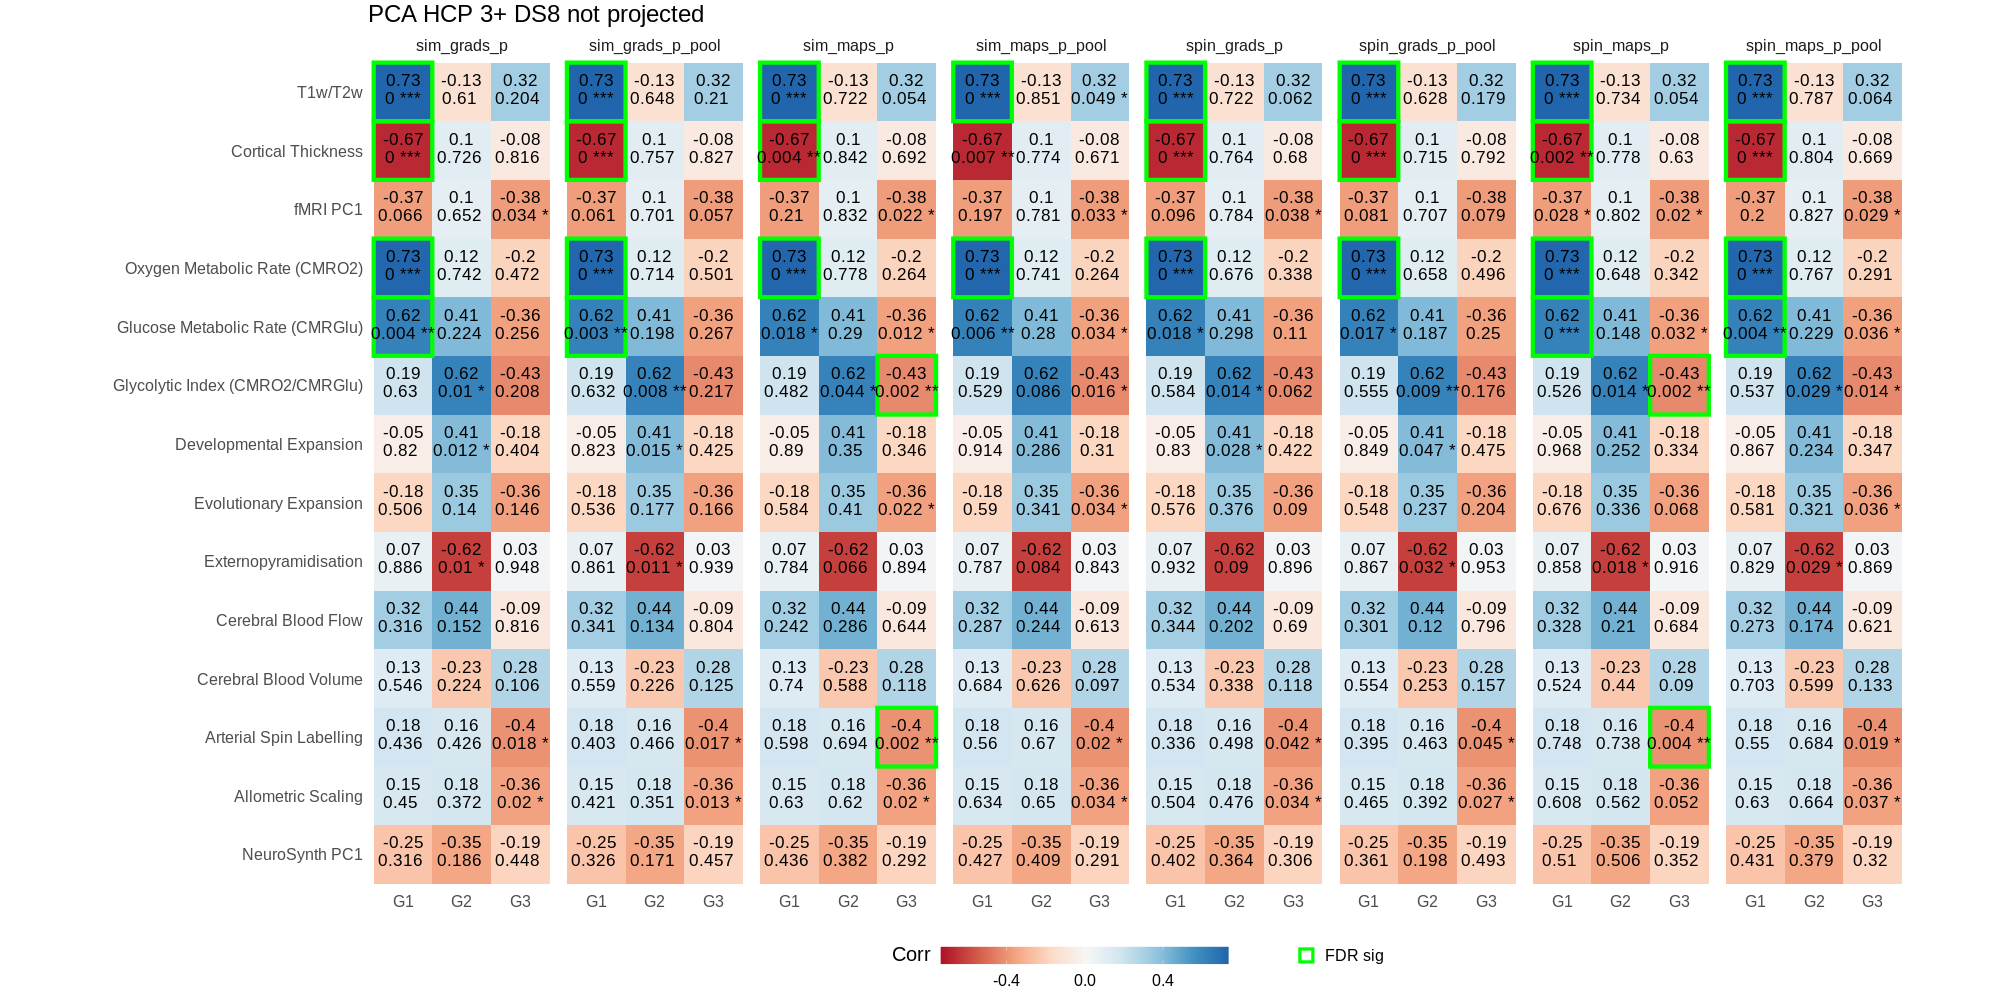

In [149]:
%%R -i corr_versions -w 2000 -h 1000
source("../code/plot_maps.R")
plot_corr_versions(corr_versions) + ggtitle('PCA HCP 3+ DS8 not projected')

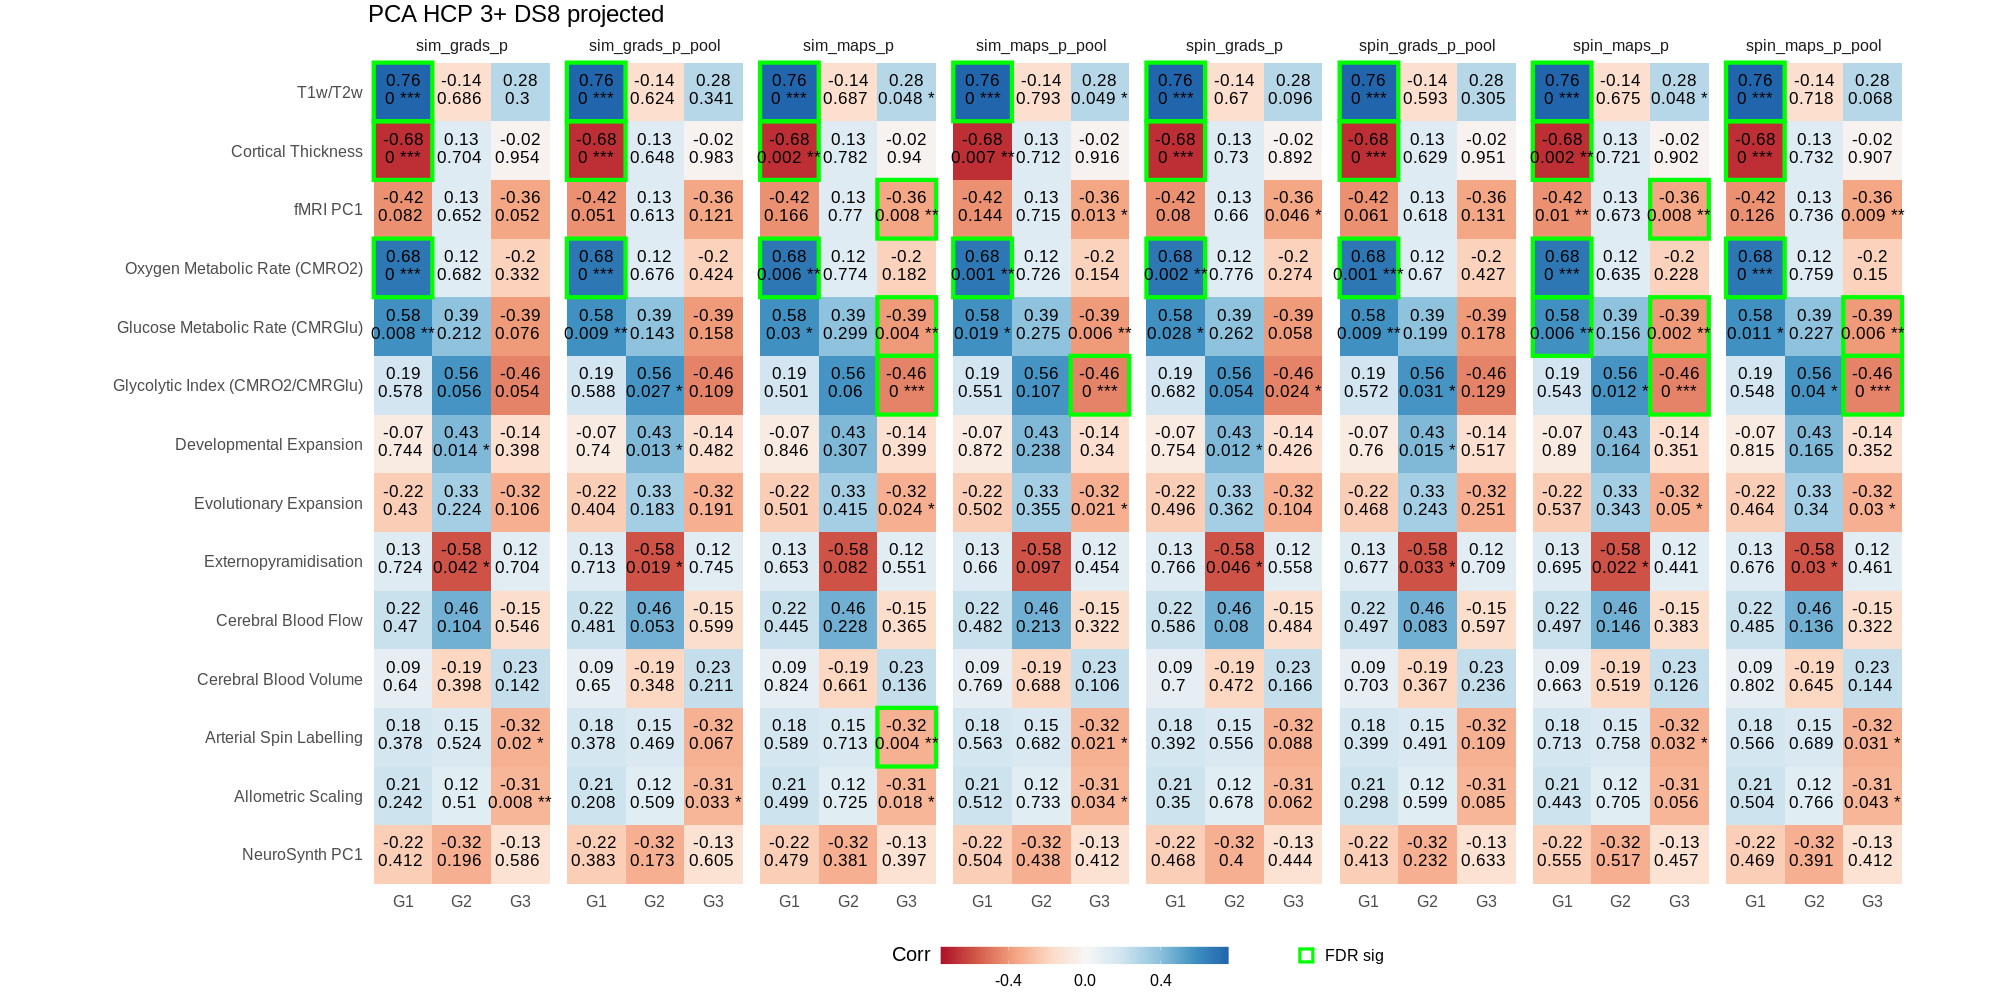

In [165]:
%%R -i corr_versions -w 2000 -h 1000
source("../code/plot_maps.R")
plot_corr_versions(corr_versions) + ggtitle('PCA HCP 3+ DS8 projected')

In [269]:
nulls_dict = {name:get_null_p(corrs, null_corrs).loc[:,['map','G','true_mean','p']].set_index(['map','G']) for name, null_corrs in null_corrs_dict.items()}
df_corr_nulls = pd.concat(nulls_dict, axis=0).reset_index().set_axis(['method','map','G','r','p'],axis=1)

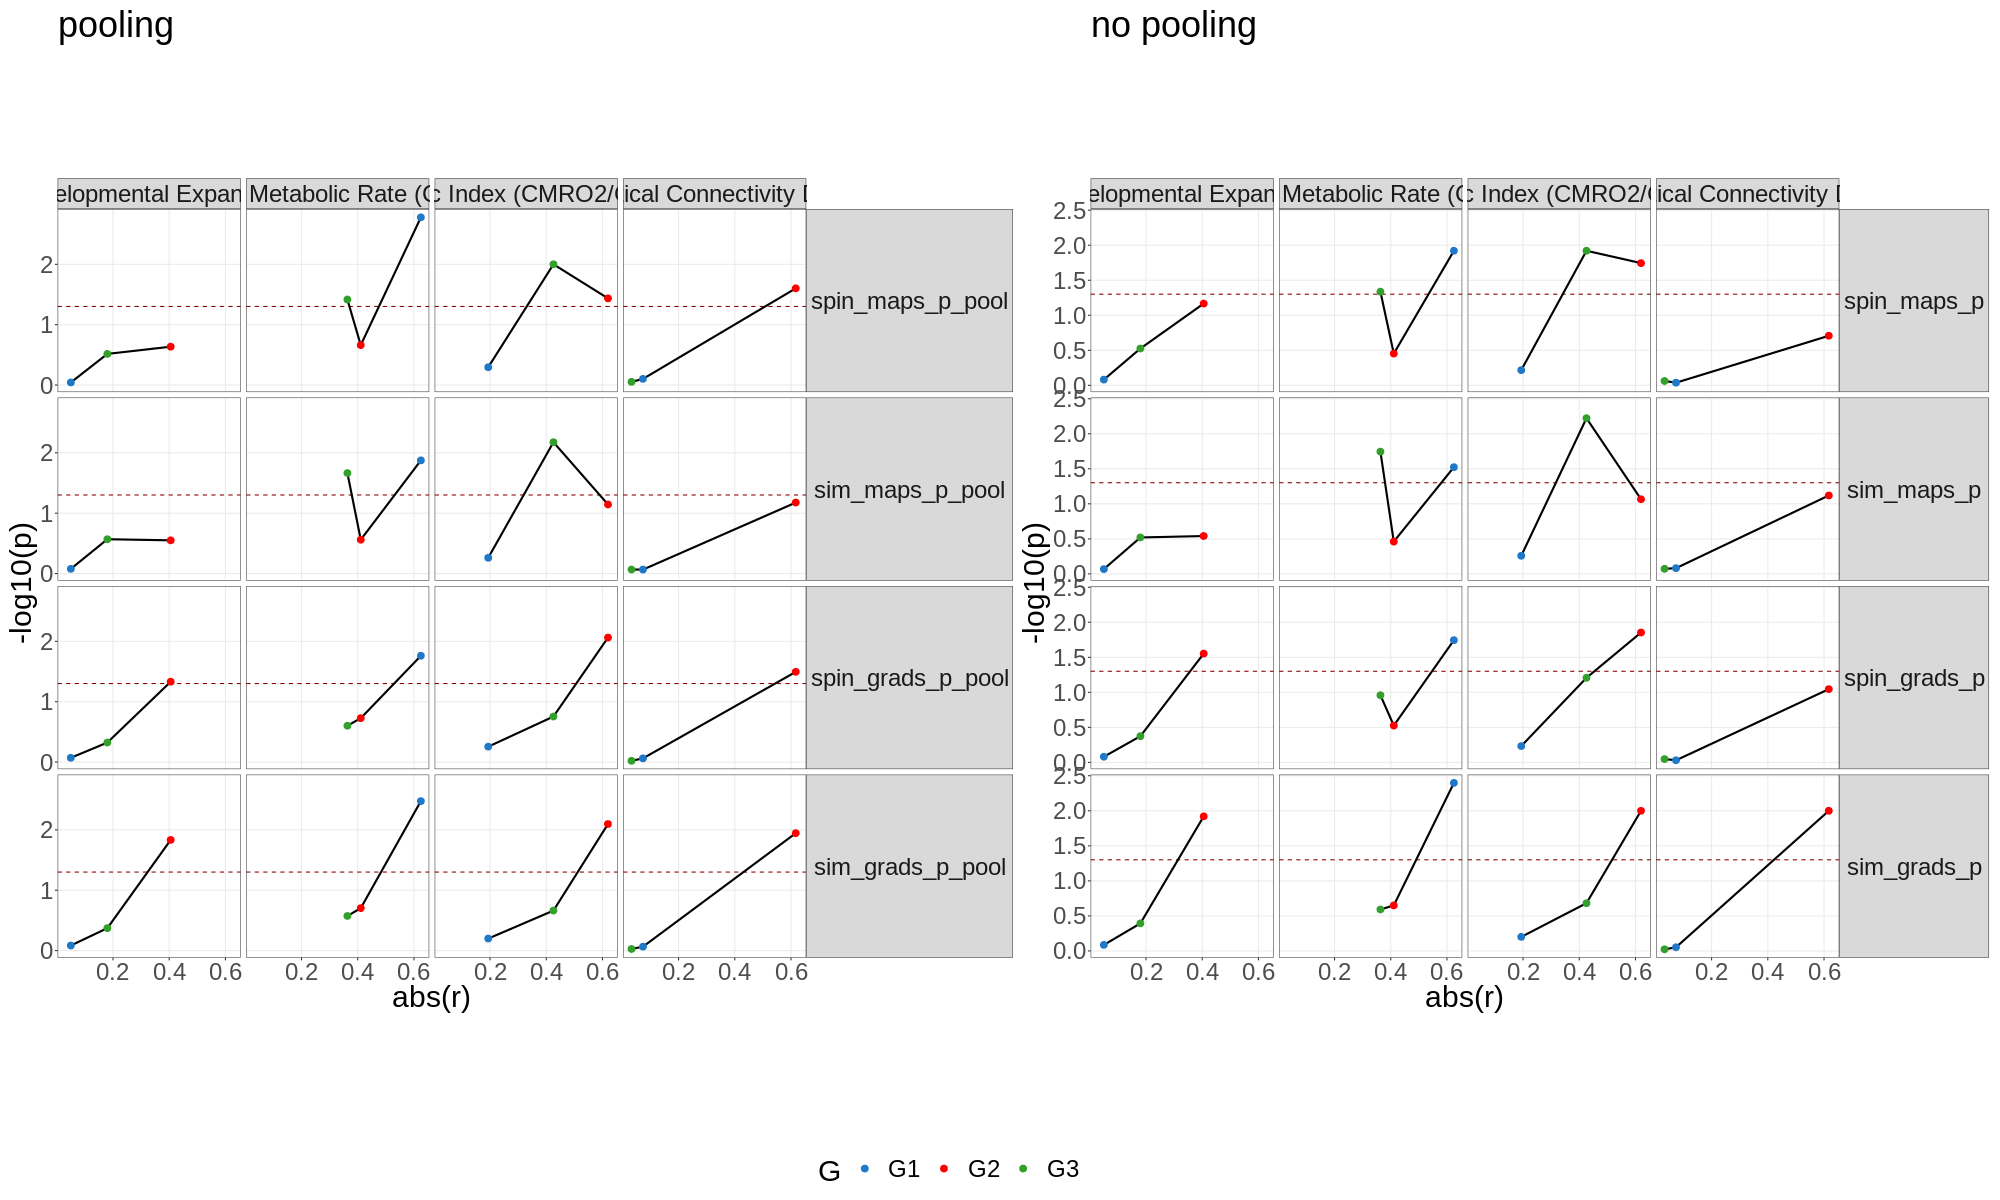

In [273]:
%%R -i df_corr_nulls -w 2000 -h 1200
library(ggrepel)
library(pals)

maps_to_flag <- c(
    'Glycolytic Index (CMRO2/CMRGlu)',
    'Glucose Metabolic Rate (CMRGlu)',
    'Intracortical Connectivity Distance',
    'Developmental Expansion')

methods_order = c(
    'spin_maps_p', 'spin_maps_p_pool',
    'sim_maps_p', 'sim_maps_p_pool',
    'spin_grads_p', 'spin_grads_p_pool',
    'sim_grads_p', 'sim_grads_p_pool'
)

df_corr_nulls <- df_corr_nulls %>%
    filter(map %in% maps_to_flag) %>%
    mutate(method = factor(method, ordered=T, levels=methods_order))

plot_p_vs_r <- function(df_corr_nulls) {
df_corr_nulls %>%
    ggplot(aes(abs(r), -log10(p))) + 
    geom_hline(yintercept=-log10(0.05), linetype=2, color='darkred') +
    facet_grid(method~map) +
    geom_line(aes(group=map), size=1) +
    geom_point(aes(color=G), size=3) +
    scale_color_manual(values=cols25(10)) +
    scale_x_continuous(breaks=c(0,.2,.4,.6)) +
    theme_bw() + 
    theme(aspect.ratio=1, panel.grid.minor=element_blank(), strip.text.y=element_text(angle=0))
}

g1 <- df_corr_nulls %>% filter(grepl('pool', method)) %>% plot_p_vs_r + ggtitle('pooling')
g2 <- df_corr_nulls %>% filter(!grepl('pool', method)) %>% plot_p_vs_r + ggtitle('no pooling')

(g1 | g2) + plot_layout(guides='collect') & theme(text=element_text(size=30), legend.position='bottom')


In [68]:
scores_plot = dm_hcp_ds9.clean_scores()
corrs = get_corrs(scores, maps, atlas='hcp')
null_corrs = null_corrs_dict['sim_grads_p']
null_p = get_null_p(corrs, null_corrs, adjust='fdr_bh')
# null_p

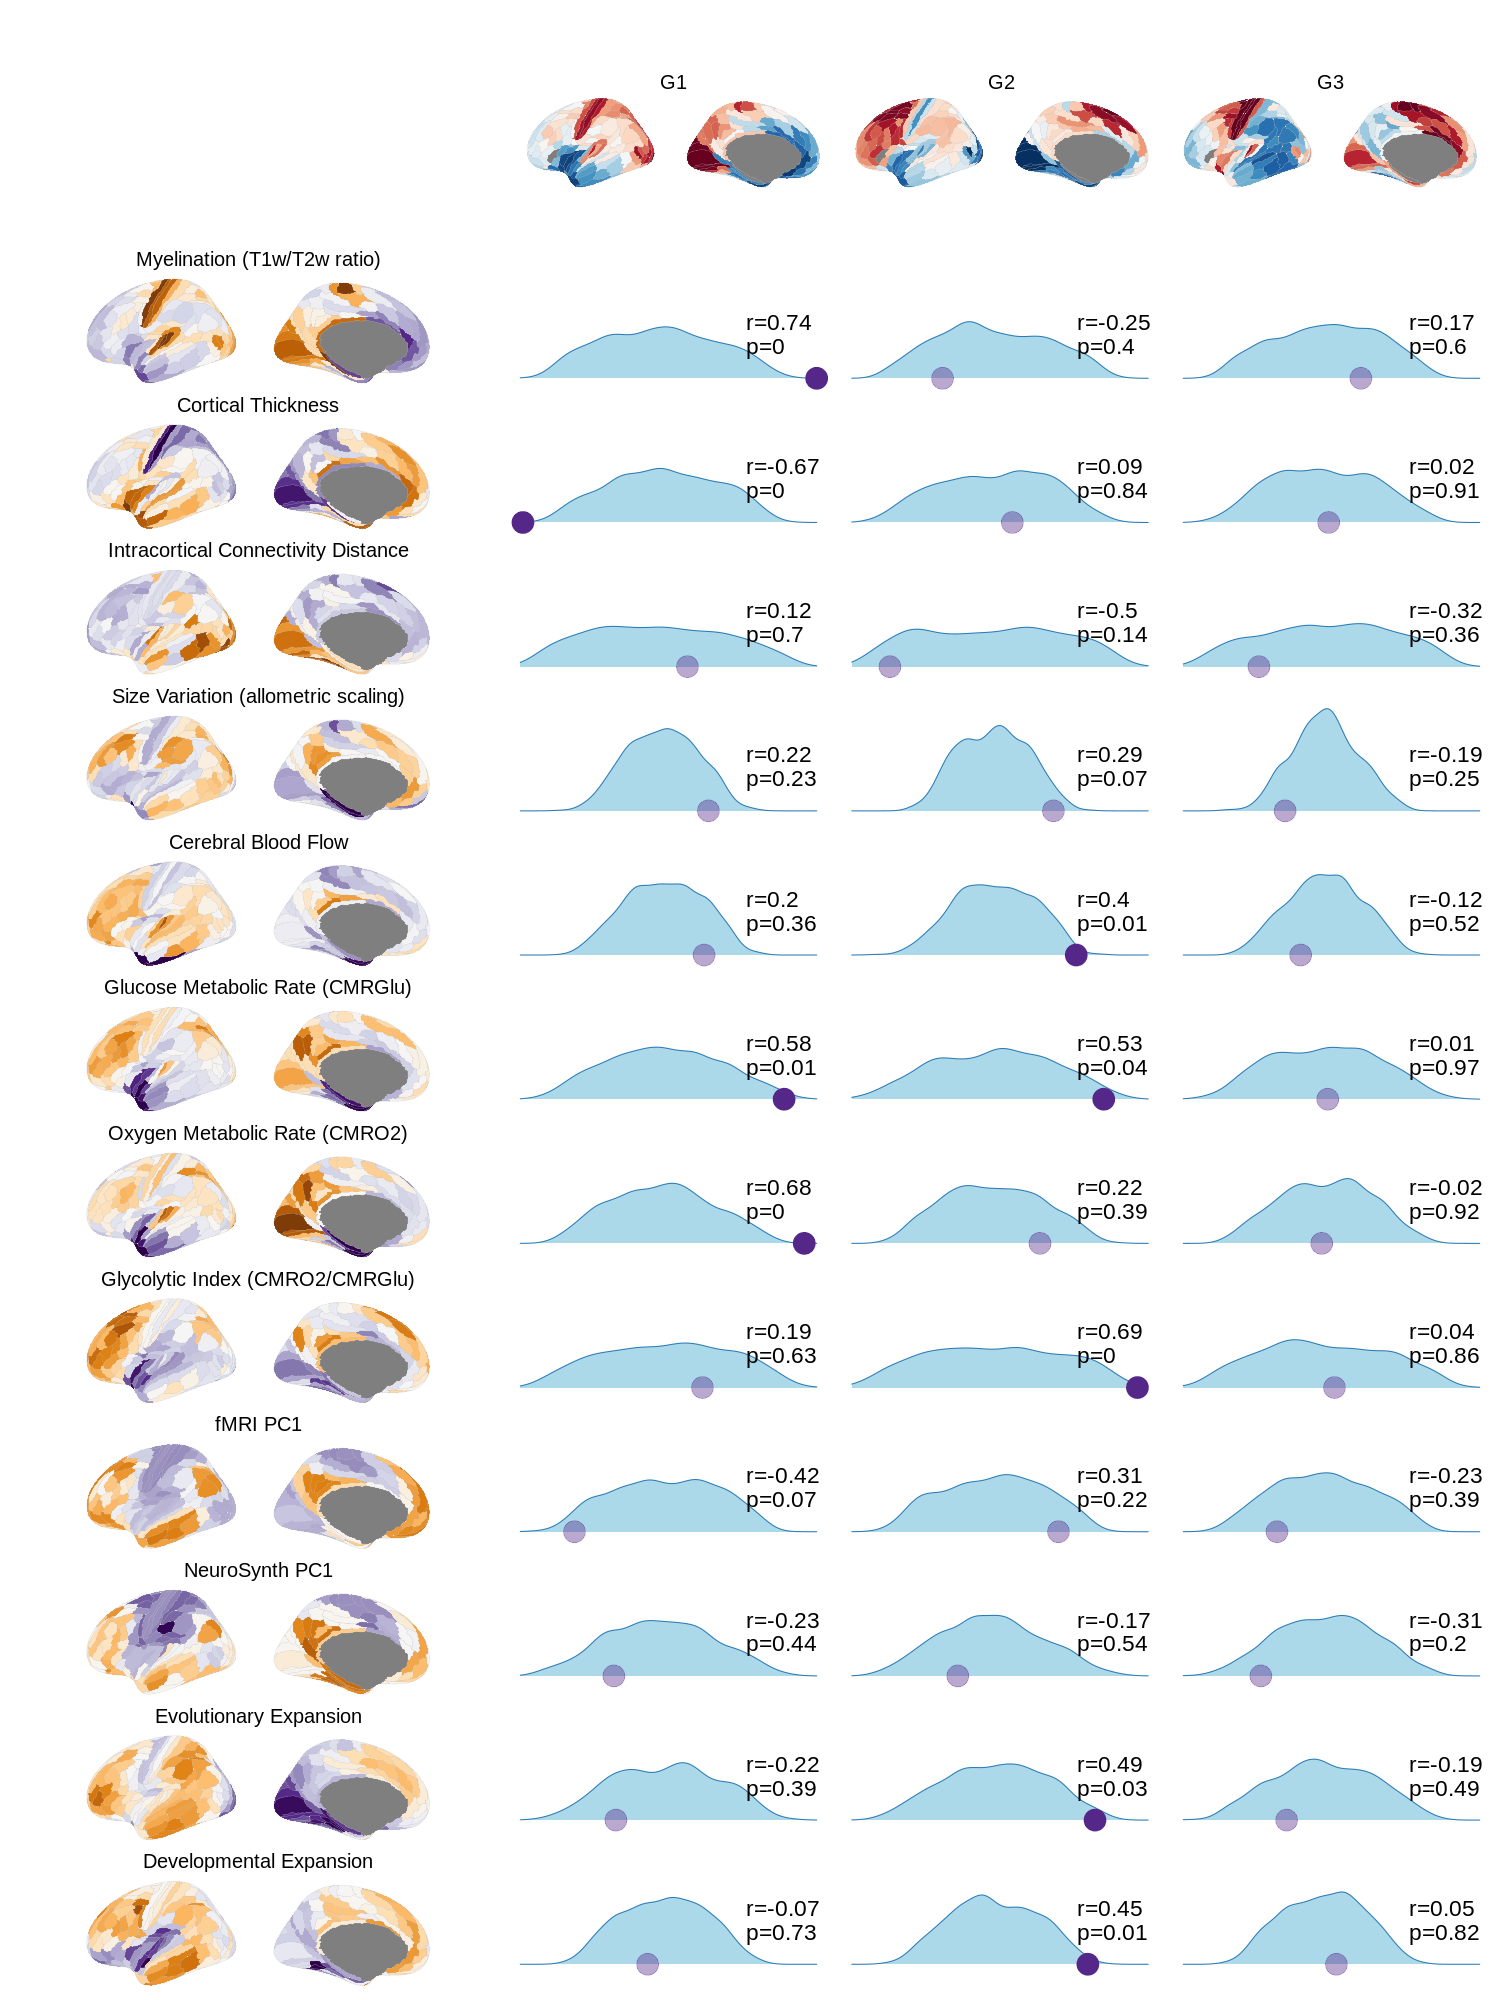

In [45]:
%%R -i corrs -i null_corrs -i null_p -i scores_plot -i maps -w 1500 -h 2000
source("../code/plot_maps.R")
source("../code/brainPlots.R")
g1 <- plot_null_corrs(corrs, null_corrs, null_p)
g2 <- plot_hcp_wide(scores_plot, spacing=0) + guides(fill='none')
g3 <- plot_maps(maps, colors=rev(brewer.puor(100)), ncol=1) + guides(fill='none')

(
    ((plot_spacer() | g2) + plot_layout(widths=c(1,2))) / 
    ((g3 | g1) + plot_layout(widths=c(1,2)))
) + plot_layout(heights=c(1.2,12))

---

# Legacy

Generate null spins/sims, or just load them, and calculate correlations with the nulls

In [11]:
generate_spins(maps, 10, outfile='../outputs/spin_maps_10.npy')

In [9]:
# null_corrs_dict = {}
# null_corrs_dict_ds8 = null_corrs_dict
# null_corrs_dict_ds7 = null_corrs_dict
null_corrs_dict = {}

In [10]:
# generate_spins(maps, 1000, '../outputs/spin_maps_v2_1000.npy')
ix_keep = [i for i in range(15) if i not in (4,9,14)]
spin_maps_1000 = np.load("../outputs/spin_maps_v2_1000.npy")[:,ix_keep,:]
null_corrs_dict['spin_maps_p'] = corr_nulls_from_maps(spin_maps_1000, scores, maps, method='pearson')
# null_corrs_dict['spin_maps_s'] = corr_nulls_from_maps(spin_maps_1000, scores, maps, method='spearman')

In [61]:
# generate_surrogates(maps, 1000, '../outputs/sim_maps_v2_1000.npy')
ix_keep = [i for i in range(15) if i not in (4,9,14)]
sim_maps_1000 = np.load("../outputs/sim_maps_v2_1000.npy")[:,ix_keep,:]
null_corrs_dict['sim_maps_p'] = corr_nulls_from_maps(sim_maps_1000, scores, maps, method='pearson')
# null_corrs_dict['sim_maps_s'] = corr_nulls_from_maps(sim_maps_1000, scores, maps, method='spearman')

In [ ]:
# Match distance matrix to PC parcels and generate surrogates
dist_mat = np.loadtxt("../data/LeftParcelGeodesicDistmat.txt")
inds = [i-1 for i in scores.index]
dist_mat_matched = dist_mat[inds,:][:,inds]
np.savetxt("../data/LeftParcelGeodesicDistmat_PCmatched.txt", dist_mat_matched)

In [126]:
# generate_surrogates(scores, 1000, 
#                     dist_mat="../data/LeftParcelGeodesicDistmat_PCmatched.txt",
#                     outfile="../outputs/sim_pcs_1000.npy")
# generate_spins_from_pcs(scores, 1000, outfile='../outputs/spin_pcs_1000.npy')

In [62]:
spin_pcs_1000 = np.load("../outputs/spin_pcs_1000.npy")
null_corrs_dict['spin_pcs_p'] = corr_nulls_from_pcs(spin_pcs_1000, scores, maps, method='pearson')
# null_corrs_dict['spin_pcs_s'] = corr_nulls_from_pcs(spin_pcs_1000, scores, maps, method='spearman')

In [63]:
sim_pcs_1000 = np.load("../outputs/sim_pcs_1000.npy")
null_corrs_dict['sim_pcs_p'] = corr_nulls_from_pcs(sim_pcs_1000, scores, maps, method='pearson')
# null_corrs_dict['sim_pcs_s'] = corr_nulls_from_pcs(sim_pcs_1000, scores, maps, method='spearman')

In [195]:
null_corrs_dict['spin_maps_p_pool'] = corr_nulls_from_maps(spin_maps_1000[:,:,:500], scores, maps, method='pearson', pool=True)
null_corrs_dict['sim_maps_p_pool'] = corr_nulls_from_maps(sim_maps_1000[:,:,:500], scores, maps, method='pearson', pool=True)
# null_corrs_dict['spin_pcs_p_pool'] = corr_nulls_from_pcs(spin_pcs_1000, scores, maps, method='pearson', pool=True)
# null_corrs_dict['sim_pcs_p_pool'] = corr_nulls_from_pcs(sim_pcs_1000, scores, maps, method='pearson', pool=True)

In [89]:
corrs = get_corrs(scores, maps, method='pearson')
# null_corrs = null_corrs_dict['sim_maps_p']
null_corrs = null_corrs_dict['sim_pcs_p']
null_p = get_null_p(corrs, null_corrs)

In [141]:
# nulls_dict = {name:get_null_p(corrs, null_corrs).melt(var_name='PC', value_name='p', ignore_index=False).set_index('PC', append=True) for name, null_corrs in null_corrs_dict.items()}
# df_nulls = pd.concat(nulls_dict, axis=1).droplevel(1, axis=1)
# df_corrs = corrs.melt(var_name='PC', value_name='r', ignore_index=False).set_index('PC', append=True)
df_corr_nulls = df_corrs.join(df_nulls).melt(ignore_index=False,id_vars=['r'], var_name='method', value_name='p').reset_index().rename({'level_0':'map'}, axis=1)
df_corr_nulls

map   PC         r          method  \
0            Myelination (T1w/T2w ratio)  PC1  0.720940     spin_maps_p   
1                     Cortical Thickness  PC1 -0.644988     spin_maps_p   
2    Intracortical Connectivity Distance  PC1  0.123493     spin_maps_p   
3    Size Variation (allometric scaling)  PC1  0.250287     spin_maps_p   
4                    Cerebral Blood Flow  PC1  0.177804     spin_maps_p   
..                                   ...  ...       ...             ...   
283      Glycolytic Index (CMRO2/CMRGlu)  PC3 -0.503211  sim_pcs_p_pool   
284                             fMRI PC1  PC3 -0.342263  sim_pcs_p_pool   
285                       NeuroSynth PC1  PC3 -0.090729  sim_pcs_p_pool   
286               Evolutionary Expansion  PC3 -0.337610  sim_pcs_p_pool   
287              Developmental Expansion  PC3 -0.227440  sim_pcs_p_pool   

            p  
0    0.000000  
1    0.005000  
2    0.395000  
3    0.157000  
4    0.234000  
..        ...  
283  0.048667  
284  0.086667  
285  0.357333  
286  0.120333  
287  0.143000  

[288 rows x 5 columns]

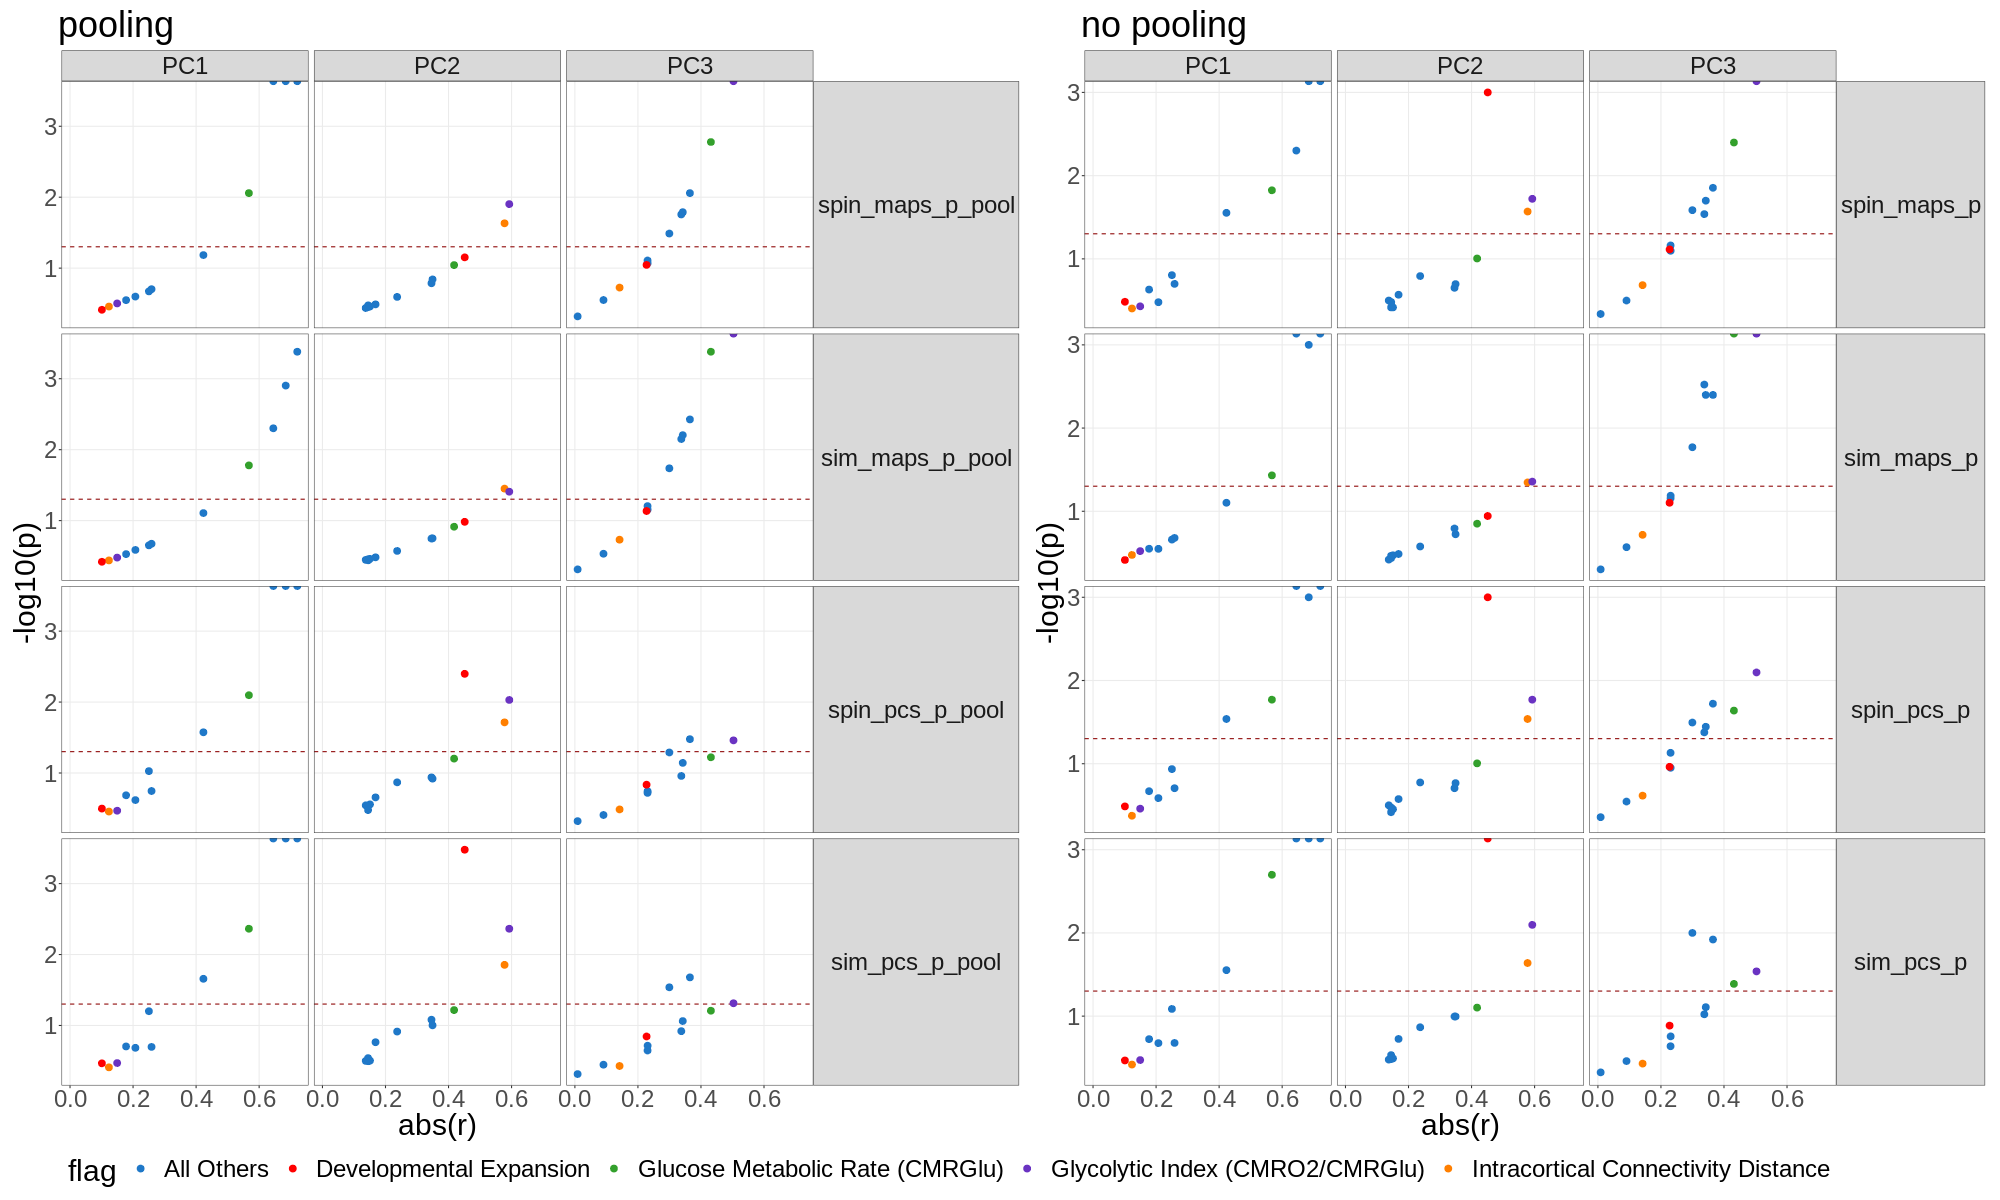

In [184]:
%%R -i df_corr_nulls -w 2000 -h 1200
library(ggrepel)
library(pals)

maps_to_flag <- c(
    'Glycolytic Index (CMRO2/CMRGlu)',
    'Glucose Metabolic Rate (CMRGlu)',
    'Intracortical Connectivity Distance',
    'Developmental Expansion')

methods_order = c(
    'spin_maps_p', 'spin_maps_p_pool',
    'sim_maps_p', 'sim_maps_p_pool',
    'spin_pcs_p', 'spin_pcs_p_pool',
    'sim_pcs_p', 'sim_pcs_p_pool'
)

df_corr_nulls <- df_corr_nulls %>%
    mutate(flag = ifelse(map %in% maps_to_flag, map,'All Others')) %>%
    mutate(method = factor(method, ordered=T, levels=methods_order))

plot_p_vs_r <- function(df_corr_nulls) {
df_corr_nulls %>%
    ggplot(aes(abs(r), -log10(p))) + 
    geom_hline(yintercept=-log10(0.05), linetype=2, color='darkred') +
    facet_grid(method~PC) +
    geom_point(aes(color=flag), size=3) +
    scale_color_manual(values=cols25(10)) +
    theme_bw() + 
    theme(aspect.ratio=1, panel.grid.minor=element_blank(), strip.text.y=element_text(angle=0))
}

g1 <- df_corr_nulls %>% filter(grepl('pool', method)) %>% plot_p_vs_r + ggtitle('pooling')
g2 <- df_corr_nulls %>% filter(!grepl('pool', method)) %>% plot_p_vs_r + ggtitle('no pooling')

(g1 | g2) + plot_layout(guides='collect') & theme(text=element_text(size=30), legend.position='bottom')


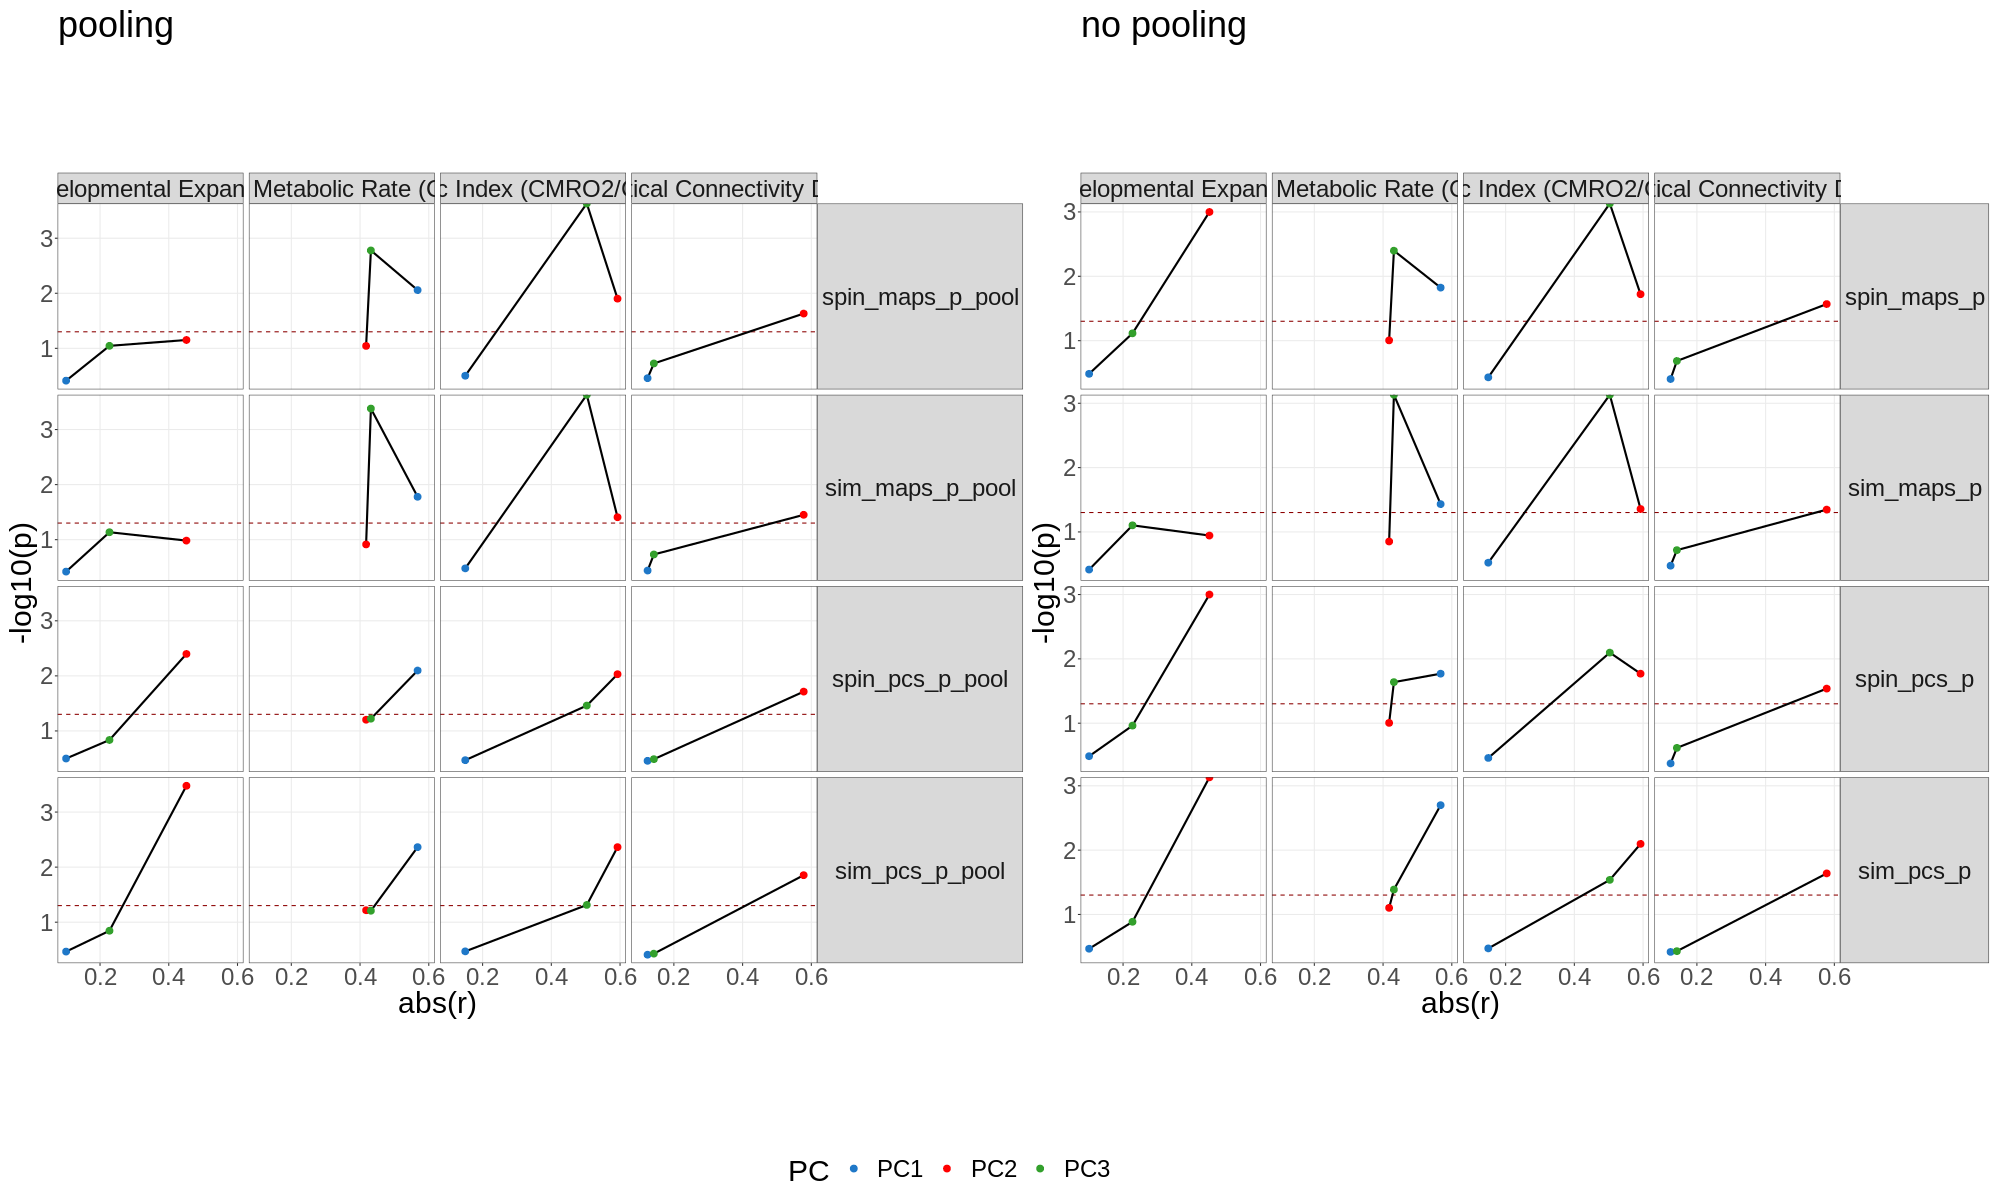

In [194]:
%%R -i df_corr_nulls -w 2000 -h 1200
library(ggrepel)
library(pals)

maps_to_flag <- c(
    'Glycolytic Index (CMRO2/CMRGlu)',
    'Glucose Metabolic Rate (CMRGlu)',
    'Intracortical Connectivity Distance',
    'Developmental Expansion')

methods_order = c(
    'spin_maps_p', 'spin_maps_p_pool',
    'sim_maps_p', 'sim_maps_p_pool',
    'spin_pcs_p', 'spin_pcs_p_pool',
    'sim_pcs_p', 'sim_pcs_p_pool'
)

df_corr_nulls <- df_corr_nulls %>%
    # mutate(flag = ifelse(map %in% maps_to_flag, map,'All Others')) %>%
    filter(map %in% maps_to_flag) %>%
    # mutate(PC = factor(PC, ordered=T, levels=c('PC1','PC2','PC3'))) %>%
    mutate(method = factor(method, ordered=T, levels=methods_order))

plot_p_vs_r <- function(df_corr_nulls) {
df_corr_nulls %>%
    ggplot(aes(abs(r), -log10(p))) + 
    geom_hline(yintercept=-log10(0.05), linetype=2, color='darkred') +
    facet_grid(method~map) +
    geom_line(aes(group=map), size=1) +
    geom_point(aes(color=PC), size=3) +
    scale_color_manual(values=cols25(10)) +
    scale_x_continuous(breaks=c(0,.2,.4,.6)) +
    theme_bw() + 
    theme(aspect.ratio=1, panel.grid.minor=element_blank(), strip.text.y=element_text(angle=0))
}

g1 <- df_corr_nulls %>% filter(grepl('pool', method)) %>% plot_p_vs_r + ggtitle('pooling')
g2 <- df_corr_nulls %>% filter(!grepl('pool', method)) %>% plot_p_vs_r + ggtitle('no pooling')

(g1 | g2) + plot_layout(guides='collect') & theme(text=element_text(size=30), legend.position='bottom')


In [90]:
print_corrs_sig(corrs, null_p)

PC1       PC2      PC3
Myelination (T1w/T2w ratio)           0.72 ***     -0.15     0.23
Cortical Thickness                   -0.64 ***      0.15    -0.01
Intracortical Connectivity Distance       0.12   -0.58 *     0.14
Size Variation (allometric scaling)       0.25      0.17  -0.3 **
Cerebral Blood Flow                       0.18      0.24  -0.37 *
Glucose Metabolic Rate (CMRGlu)        0.57 **      0.42  -0.43 *
Oxygen Metabolic Rate (CMRO2)         0.68 ***      0.14    -0.23
Glycolytic Index (CMRO2/CMRGlu)           0.15   0.59 **   -0.5 *
fMRI PC1                               -0.42 *      0.14    -0.34
NeuroSynth PC1                           -0.21     -0.35    -0.09
Evolutionary Expansion                   -0.26      0.35    -0.34
Developmental Expansion                   -0.1  0.45 ***    -0.23

In [32]:
scores_plot = dm_hcp_ds9.clean_scores()

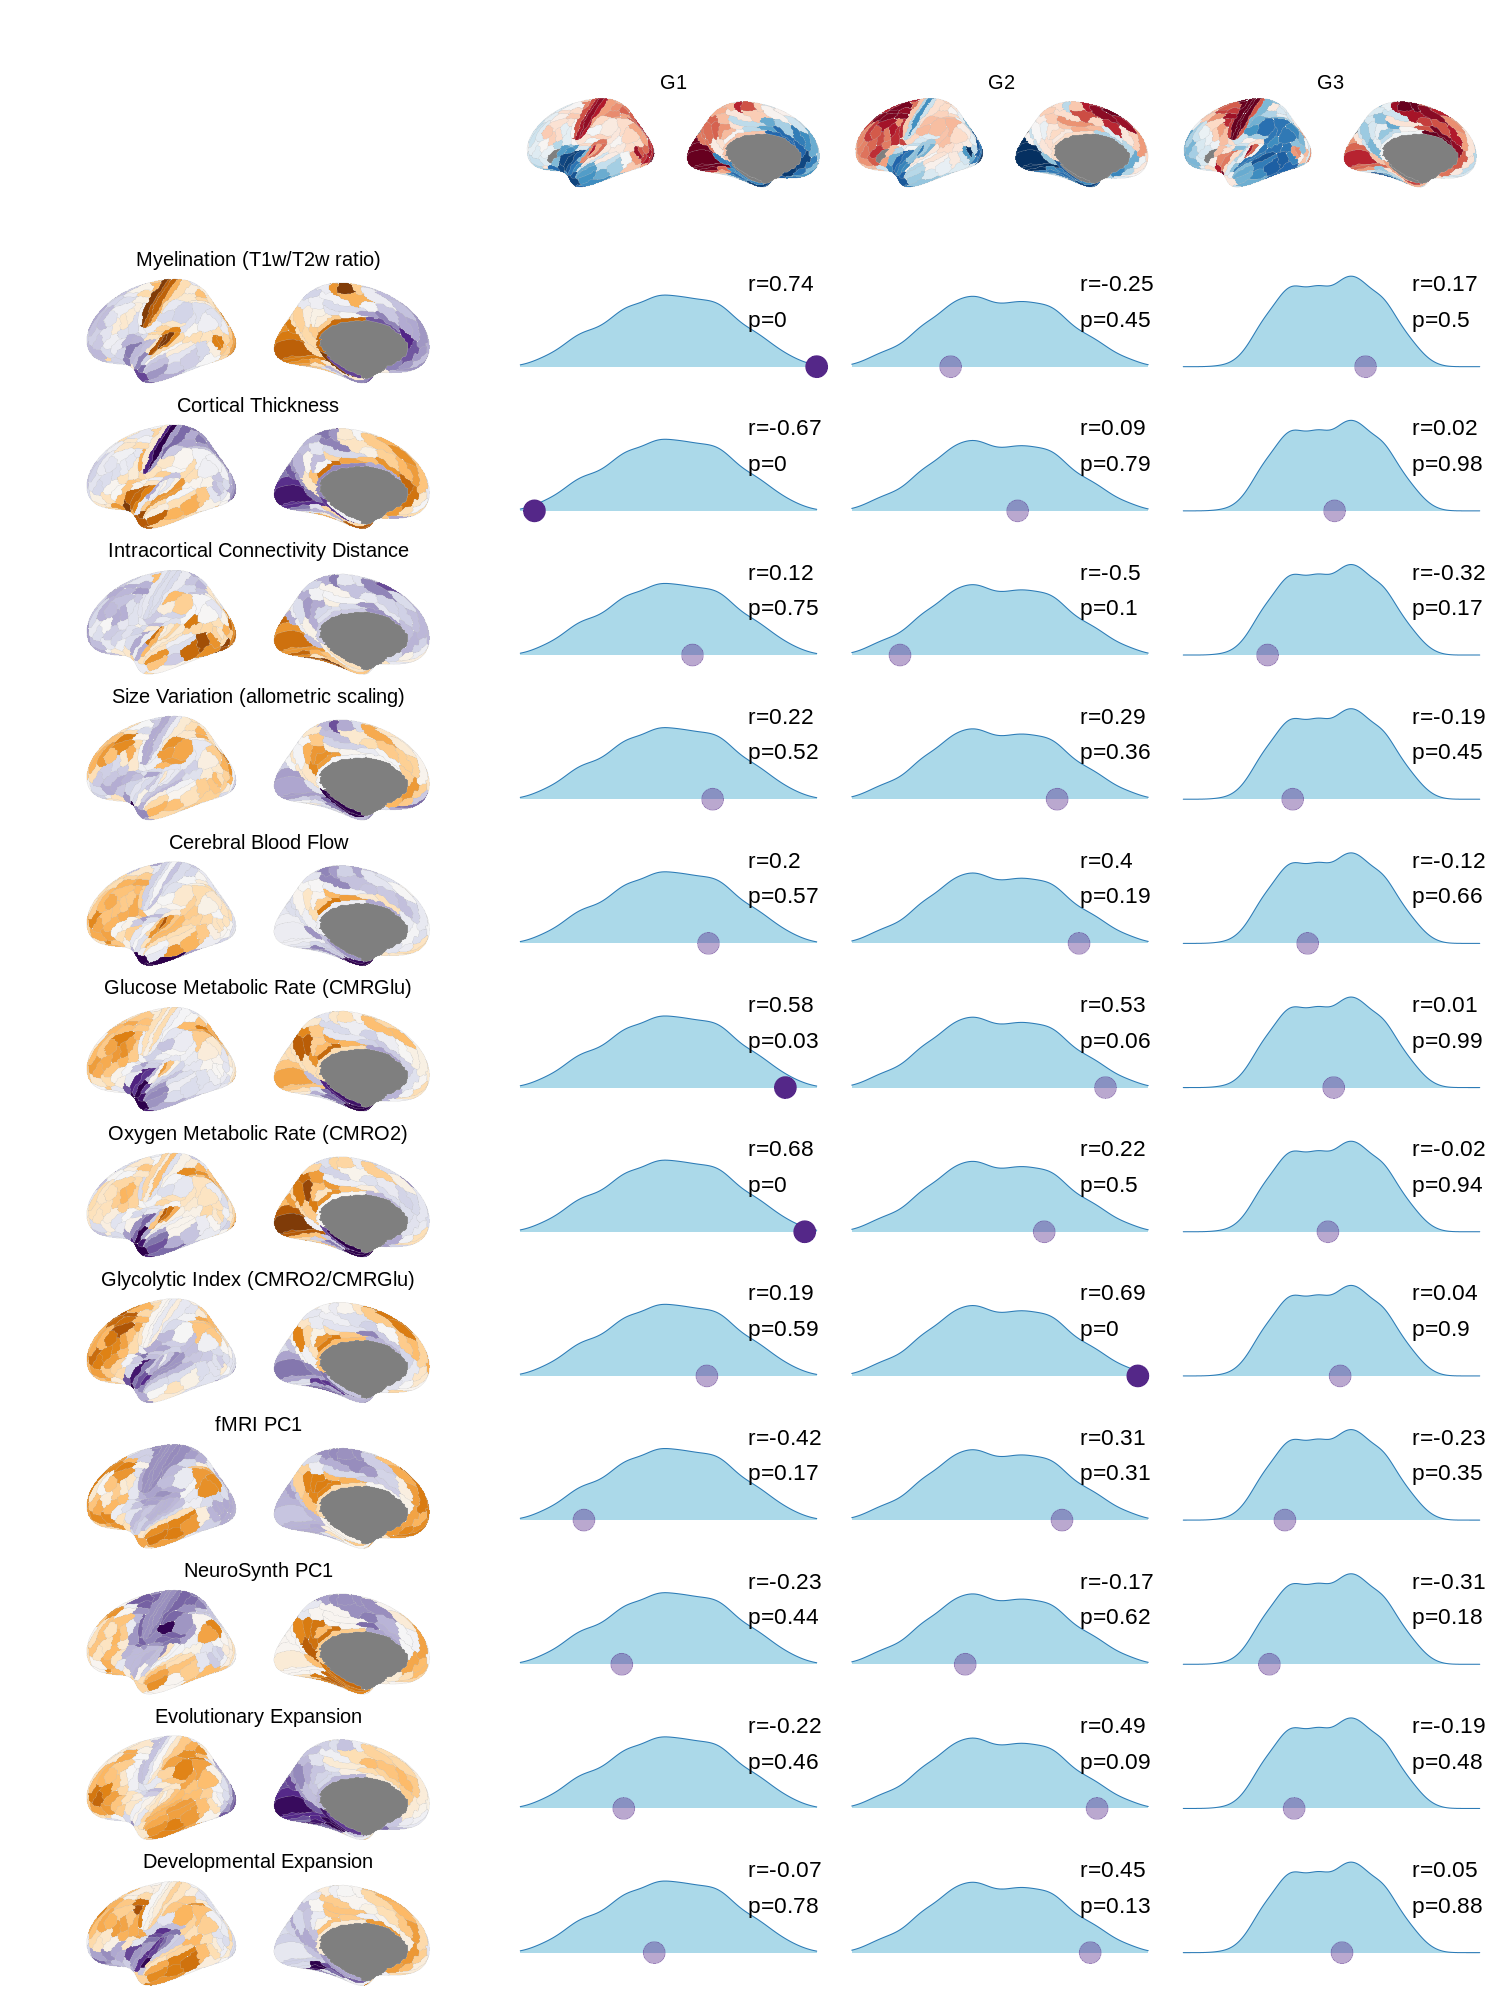

In [33]:
%%R -i corrs -i null_corrs -i null_p -i scores_plot -i maps -w 1500 -h 2000
source("../code/plot_maps.R")
source("../code/brainPlots.R")
g1 <- plot_null_corrs(corrs, null_corrs, null_p)
g2 <- plot_hcp_wide(scores_plot, spacing=0) + guides(fill='none')
g3 <- plot_maps(maps, colors=rev(brewer.puor(100)), ncol=1) + guides(fill='none')

(
    ((plot_spacer() | g2) + plot_layout(widths=c(1,2))) / 
    ((g3 | g1) + plot_layout(widths=c(1,2)))
) + plot_layout(heights=c(1.2,12))

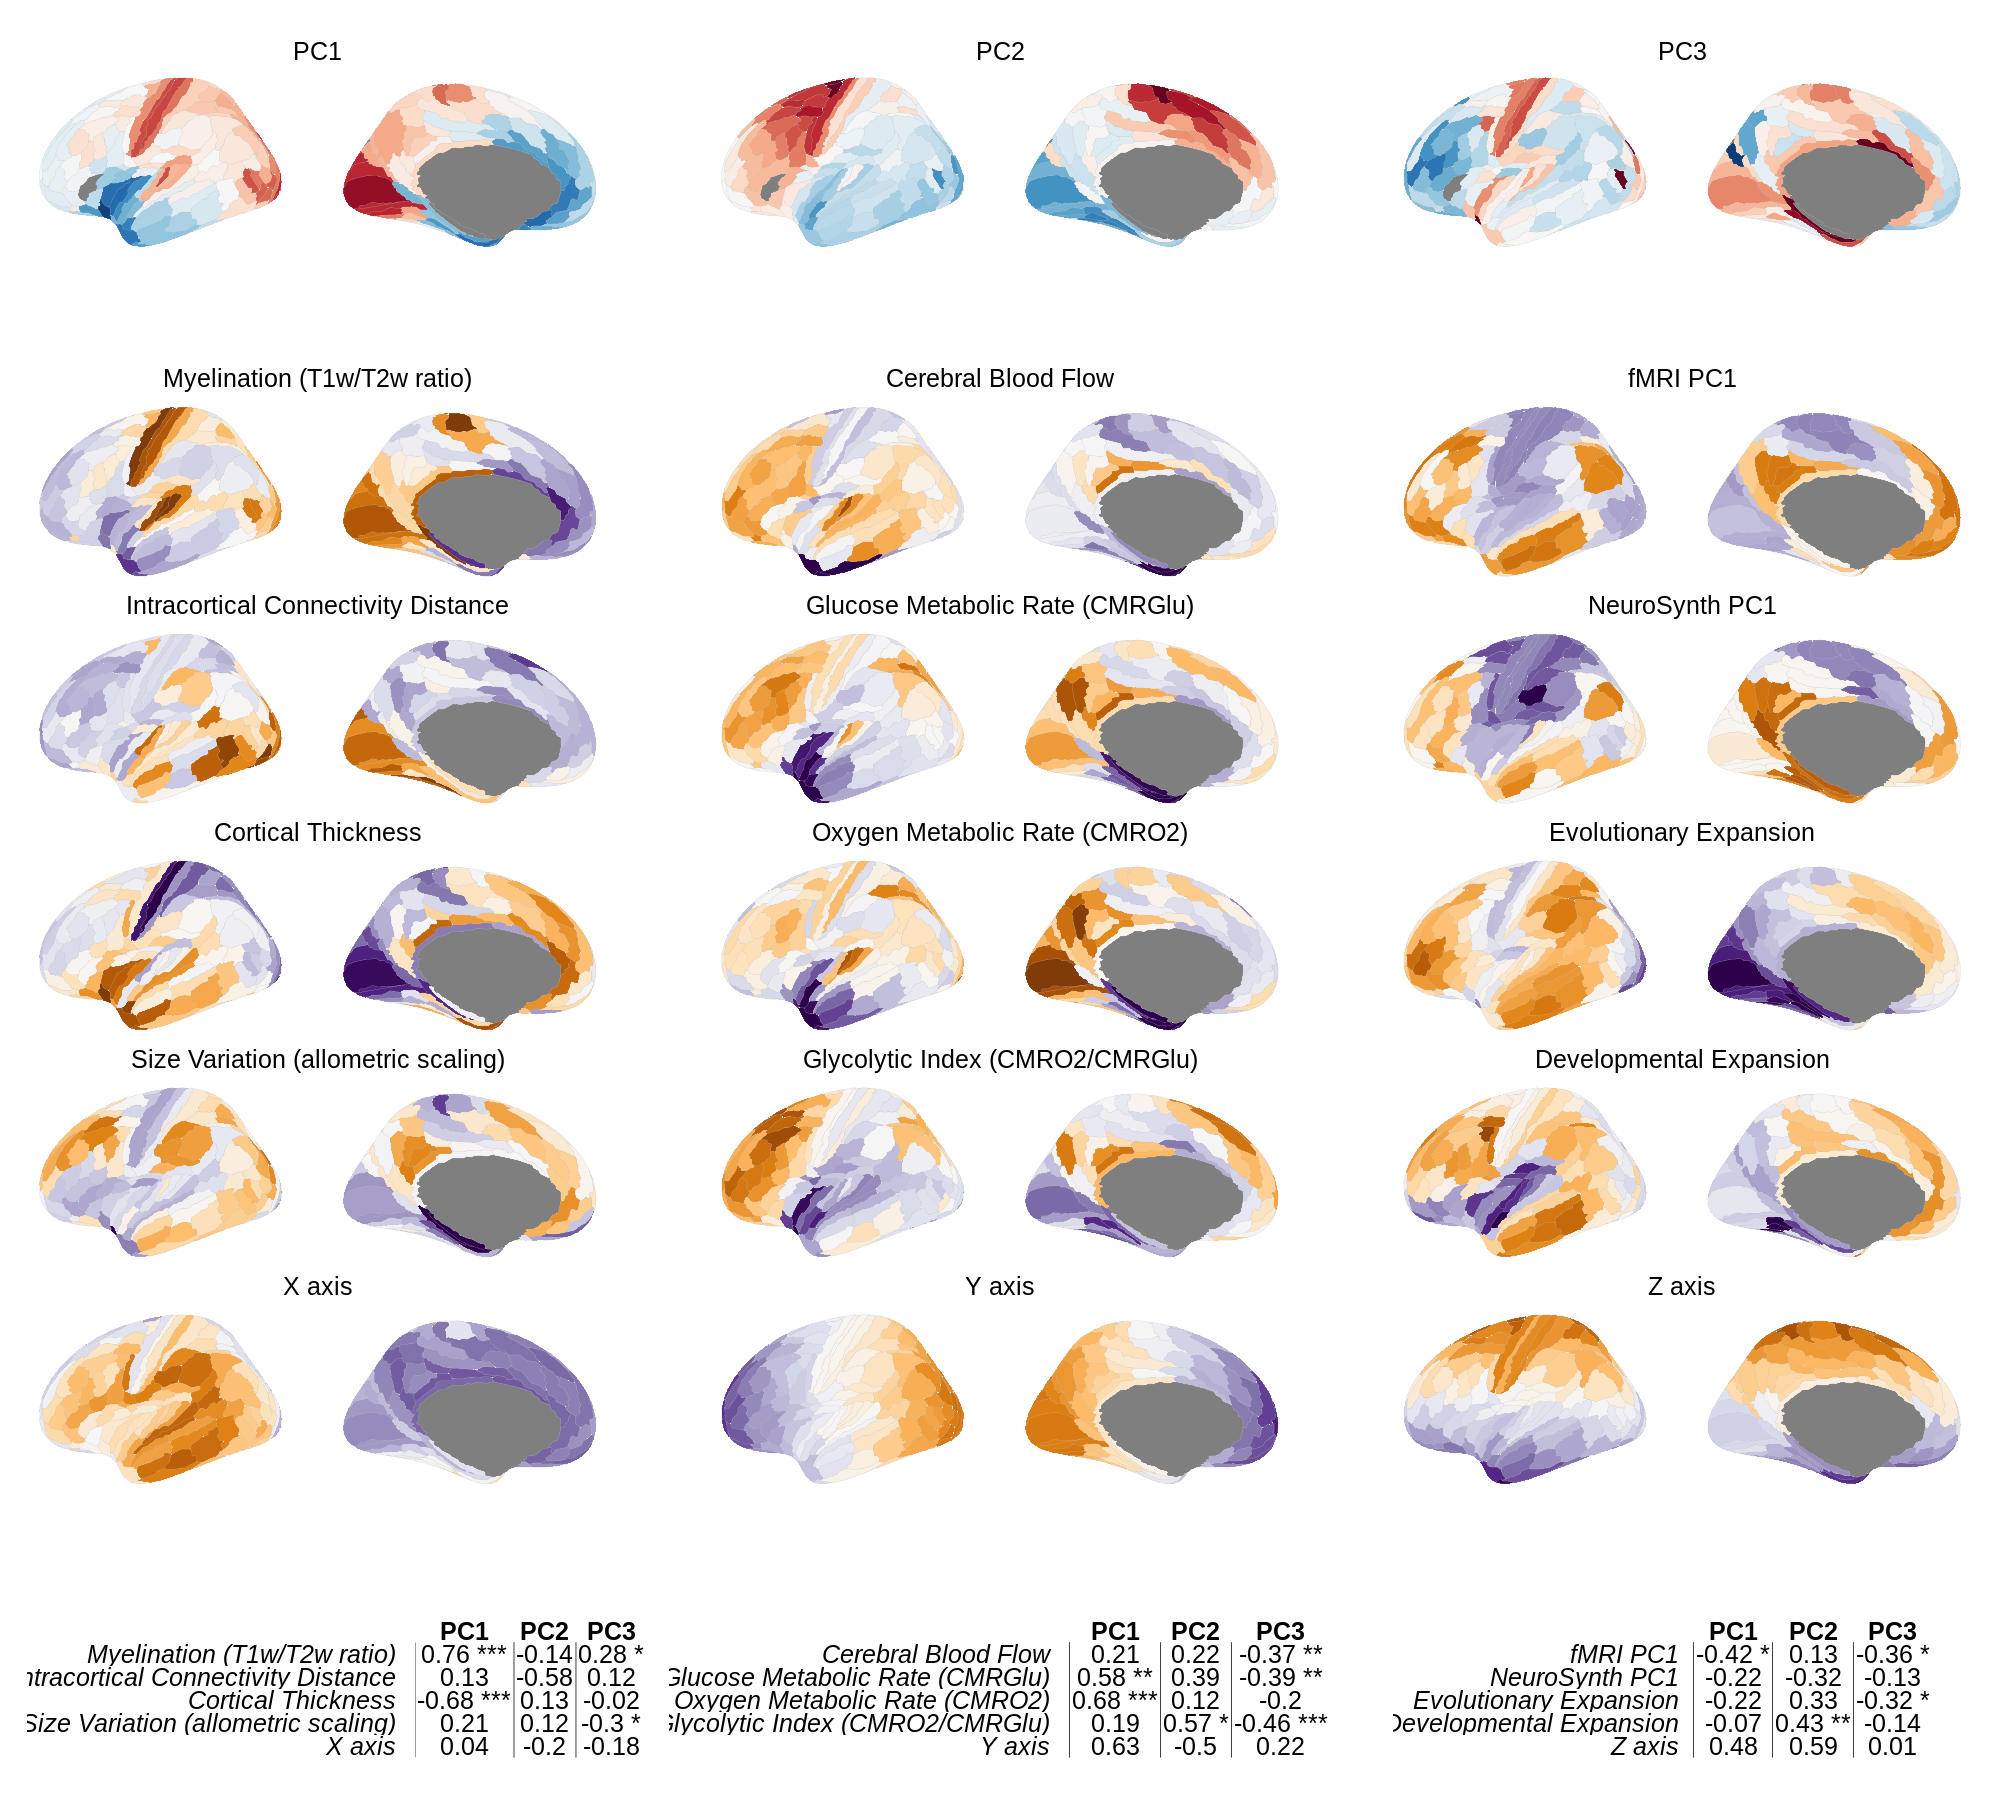

In [615]:
%%R -w 2000 -h 1800 -i maps_plot -i scores_plot -i map_corrs_sig
library(ggpubr)
g2 <- plot_hcp_wide(scores_plot) + guides(fill='none') + theme(strip.text.x = element_text(size=25))
g3 <- plot_maps(maps_plot, colors=rev(brewer.puor(100))) + guides(fill='none') + theme(strip.text.x = element_text(size=25))
gt1 <- ggtexttable(map_corrs_sig[1:5,], theme=ttheme('minimal', base_size=25, padding = unit(c(5, 5, 5, 5), "pt")))
gt2 <- ggtexttable(map_corrs_sig[6:10,], theme=ttheme('minimal', base_size=25, padding = unit(c(5, 5, 5, 5), "pt")))
gt3 <- ggtexttable(map_corrs_sig[11:15,], theme=ttheme('minimal', base_size=25, padding = unit(c(5, 5, 5, 5), "pt")))

(g2 / g3 / (gt1 | gt2 | gt3)) + plot_layout(heights=c(1,6,1))

In [90]:
%%R -i null_corrs

# null_corrs$PC1 %>% density %>%

null_corrs <- null_corrs %>% gather(PC, corr, -map)

density_list <- null_corrs %>% group_by(PC, map) %>% group_map(~ density(.$corr))
density_groups <- null_corrs %>% unique(PC, map)

get_density_df <- function(density, PC) {
    density_df <- data.frame(x=density$x, y=density$y) %>% 
            mutate(q = ifelse(y < quantile(.$y, .05), 'lo', ifelse(y > quantile(.$y, .95), 'hi', 'mid'))) %>% 
            mutate(PC = PC)
    return(density_df)
}

for 

density_df <- rbind(
    get_density_df(density_list[[1]], 'PC1'),
    get_density_df(density_list[[2]], 'PC2'),
    get_density_df(density_list[[3]], 'PC3')
)
density_df %>% head

# ggplot() + 
#     facet_grid(factor(map, levels=unique(null_corrs$map))~pc, switch='y') +
#     geom_density(aes(corr), color=mycolors[5]) +
#     theme_minimal() +
#     theme(
#           strip.text.y.left = element_blank(),
#           panel.grid = element_blank(),
#           axis.text.y = element_blank(),
#           text = element_text(size=30)
#          )
    

           x            y  q  PC
1 -0.8415793 5.655989e-05 lo PC1
2 -0.8382415 7.350975e-05 lo PC1
3 -0.8349037 9.479246e-05 lo PC1
4 -0.8315659 1.213021e-04 lo PC1
5 -0.8282281 1.540666e-04 lo PC1
6 -0.8248903 1.942581e-04 lo PC1


---

---

In [508]:
selected_maps = {
    #PC1
    'thickness':'Thickness',
    'T1T2':'Myelination (T1w/T2w ratio)',
    'glasser_CMRO2':'Oxygen Metabolic Rate (CMRO2)',
    #PC2
    'hill.dev_remapped':'Developmental Expansion',
    'externopyramidisation':'Intracortical Connectivity Distance',
    'glasser_GI':'Glycolytic Index (CMRO2/CMRGlu)',
    #PC3
    'allom':'Size Variation (allometric scaling)',
    'CBF':'Cerebral Blood Flow',
    'glasser_CMRGlu':'Glucose Metabolic Rate (CMRGlu)',
    #axes
    'x':'X axis',
    'y':'Y axis',
    'z':'Z axis'
}

# maps = maps_jakob.loc[:, list(selected_maps.keys())]
maps = maps_jakob
maps

CBF   G1_fMRI  PC1_AHBA  PC1_neurosynth      T1T2     allom  \
region                                                                     
V1     -0.179597 -0.750526 -2.359875        0.261369  1.977036 -1.085134   
MST     0.415531 -1.042511 -0.667729       -0.536989  1.575121  0.965346   
V6     -0.433862 -1.135492 -1.890494        0.056781  1.647248 -0.020746   
V2     -0.156811 -0.933047 -2.073466        0.056781  1.665496 -1.157744   
V3     -0.268078 -0.953694 -1.969166        0.056781  1.430449 -0.624528   
...          ...       ...       ...             ...       ...       ...   
STSva  -0.064344  1.434124  0.899926        1.234535 -0.795757  0.609727   
TE1m    1.361941  1.611986  0.713989        0.056781 -0.634758  0.906969   
PI     -0.387085 -0.607650  1.448596        0.056781 -1.391843  0.118060   
a32pr  -0.818520  0.184512  1.056372       -0.034157 -1.033015  0.730798   
p24    -0.207541  0.131940  2.303697       -0.032692 -2.089803  0.720717   

             asl  curvature  externopyramidisation   geodist  ...  \
region                                                        ...   
V1     -0.085518   1.555901               1.769126 -1.975811  ...   
MST     0.263112  -0.905143               0.630473 -0.100868  ...   
V6     -0.355929  -0.366673              -1.006875 -1.563375  ...   
V2     -0.267413   1.427644               1.377546 -1.930489  ...   
V3     -0.302699   1.207608               1.888340 -1.902737  ...   
...          ...        ...                    ...       ...  ...   
STSva   0.071231  -1.014288               1.400205  0.778556  ...   
TE1m    0.899422   1.246423              -0.677230  0.405919  ...   
PI     -0.586942  -3.391453              -1.012710  0.297004  ...   
a32pr  -0.379692  -1.038997              -0.618001 -0.463889  ...   
p24     0.046679   0.295577              -0.815436 -0.478000  ...   

        glasser_CBV  glasser_CMRGlu  glasser_CMRO2  glasser_GI  \
region                                                           
V1         2.293495        1.231160       2.873226   -1.523300   
MST       -0.273515        0.017804       0.318382   -0.392062   
V6         0.445668        0.515730       1.291453   -0.755553   
V2         2.718926        0.871595       2.060033   -1.113092   
V3         1.801476        0.480104       0.991689   -0.421922   
...             ...             ...            ...         ...   
STSva     -0.442127       -1.356592      -1.549051   -0.482769   
TE1m      -0.185135       -0.469423      -1.006154    0.461361   
PI         2.077343       -2.885445      -2.744273   -1.762716   
a32pr     -0.007437        0.004487      -0.582358    0.786865   
p24        0.349206       -0.612586      -0.442012   -0.562168   

        hill.dev_remapped  hill.evo_remapped  thickness         x         y  \
region                                                                        
V1              -0.275131          -2.446501  -2.310289 -1.255505  1.560962   
MST              0.246052           0.067569  -0.815568  0.738100  1.155091   
V6              -0.610757          -1.870358  -1.721457 -0.966524  1.438821   
V2              -0.614974          -2.070317  -2.030079 -1.142430  1.510433   
V3              -0.479010          -1.813154  -1.497054 -0.879968  1.576216   
...                   ...                ...        ...       ...       ...   
STSva            1.170922           1.189967   0.205376  1.176556 -0.238875   
TE1m             1.626480           1.581797   1.084687  1.884027  0.182489   
PI              -2.009474          -0.268852  -0.240927  0.744796 -0.359852   
a32pr            0.832526           0.996262   1.023028 -1.380942 -1.199160   
p24              0.195576           0.779930   1.888698 -1.548492 -1.389873   

               z  
region            
V1     -0.583163  
MST    -0.203728  
V6      0.519752  
V2     -0.497031  
V3     -0.374542  
...          ...  
STSva  -1.290717  
TE1m   -1.208325  
PI     -1.148027  
a32pr   0.412853  
p24    -0.2

In [511]:
data_dir = "~/rds/rds-cam-psych-transc-Pb9UGUlrwWc/Cam_LIBD/AHBA_data/abagen-data/expression/"
hcp_base = pcaVersion(pd.read_csv(data_dir + 'hcp_base.csv', index_col=0))
# hcp_3donors = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors.csv', index_col=0))
# hcp_3donors_ds7 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds7.csv', index_col=0))
hcp_3donors_ds8 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds8.csv', index_col=0))
# hcp_3donors_ds9 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds9.csv', index_col=0))

New PCA version
New PCA version


Get correlations

In [512]:
version = hcp_3donors_ds8
scores = hcp_base.score_from(hcp_3donors_ds8).iloc[:,:3].apply(lambda x: (x-np.mean(x))/np.std(x))

corrs = get_corrs(scores, maps, method='spearman')
corrs.style.format('{:.2f}')

In [338]:
null_corrs = {}

Random shuffles?

In [339]:
generate_shuffles(maps)
shuffle_maps = np.load("../outputs/shuffle_maps_1000.npy")

null_corrs_dict['shuffle'] = corr_nulls_from_maps(shuffle_maps, scores, maps)

Spins

In [ ]:
spin_maps_1000 = np.load("../outputs/spin_maps_1000.npy")
map_inds = maps_jakob.columns.get_indexer(maps.columns)
spin_maps = spin_maps_1000[:,map_inds,:]
null_corrs_dict['spin_maps_pe'] = corr_nulls_from_maps(
    spin_maps, scores, maps, method='pearson')

In [ ]:
null_corrs_dict['spin_maps_sp'] = corr_nulls_from_maps(
    spin_maps, scores, maps, method='spearman')

Spin PCs instead?

In [ ]:
spin_pcs_1000 = np.load("../outputs/spin_pcs_1000.npy")
spin_pcs = spin_pcs_1000
null_corrs_dict['spin_pcs_pe'] = corr_nulls_from_pcs(
    spin_pcs, scores, maps, method='pearson')
null_corrs_dict['spin_pcs_sp'] = corr_nulls_from_pcs(
    spin_pcs, scores, maps, method='spearman')

What if we use surrogate brain maps instead of spins?

In [ ]:
generate_surrogates(maps, 1000, '../outputs/sim_maps2_1000.npy')
# sim_maps_1000 = np.load("../outputs/sim_maps_1000.npy")
# null_corrs_dict['sim_maps_pe'] = corr_nulls_from_maps(
#     sim_maps_1000, scores, maps, method='pearson')
# null_corrs_dict['sim_maps_sp'] = corr_nulls_from_maps(
#     sim_maps_1000, scores, maps, method='spearman')

In [140]:
# Match distance matrix to PC parcels and generate surrogates
dist_mat = np.loadtxt("../data/LeftParcelGeodesicDistmat.txt")
inds = [i-1 for i in scores.index]
dist_mat_matched = dist_mat[inds,:][:,inds]
np.savetxt("../data/LeftParcelGeodesicDistmat_PCmatched.txt", dist_mat_matched)

In [ ]:
# generate_surrogates(scores, 1000, 
#                     dist_mat="../data/LeftParcelGeodesicDistmat_PCmatched.txt",
#                     outfile="../outputs/sim_pcs_1000.npy")

In [340]:
sim_pcs_1000 = np.load("../outputs/sim_pcs_1000.npy")
# sim_pcs_1000.shape
null_corrs_dict['sim_pcs_pe'] = corr_nulls_from_pcs(
    sim_pcs_1000, scores, maps, method='pearson')
null_corrs_dict['sim_pcs_sp'] = corr_nulls_from_pcs(
    sim_pcs_1000, scores, maps, method='spearman')

## Analyze!

Get p values and significance

In [503]:
corrs = get_corrs(scores, maps, method='pearson')
null_corrs = null_corrs_dict['spin_maps_pe']
null_p = get_null_p(corrs, null_corrs)

KeyError: 'G1_fMRI'

In [358]:
map_corrs_sig = (corrs
 .loc[null_sig.index]
 .round(2).astype('string')
 .where(null_p > .05, other = lambda x: x+' *')
 .where(null_p > .01, other = lambda x: x+'*')
 .where(null_p > .001, other = lambda x: x+'*')
)
# map_corrs_sig.to_csv("../outputs/map_corrs_sig.csv")
map_corrs_sig

PC1      PC2       PC3
thickness              -0.66 ***     0.11       0.0
T1T2                    0.79 ***     -0.2      0.27
glasser_CMRO2           0.66 ***     0.11     -0.07
hill.dev_remapped          -0.14   0.38 *     -0.13
externopyramidisation       0.12  -0.66 *      0.11
glasser_GI                  0.15   0.58 *  -0.43 **
allom                       0.17      0.1     -0.12
CBF                         0.05     0.22  -0.44 **
glasser_CMRGlu            0.51 *     0.43     -0.29
x                           0.04    -0.23     -0.21
y                           0.68    -0.56      0.26
z                           0.48     0.56      0.08

In [359]:
maps_order = maps.loc[:, null_sig.index]
scores_plot = scores.join(get_labels_hcp())

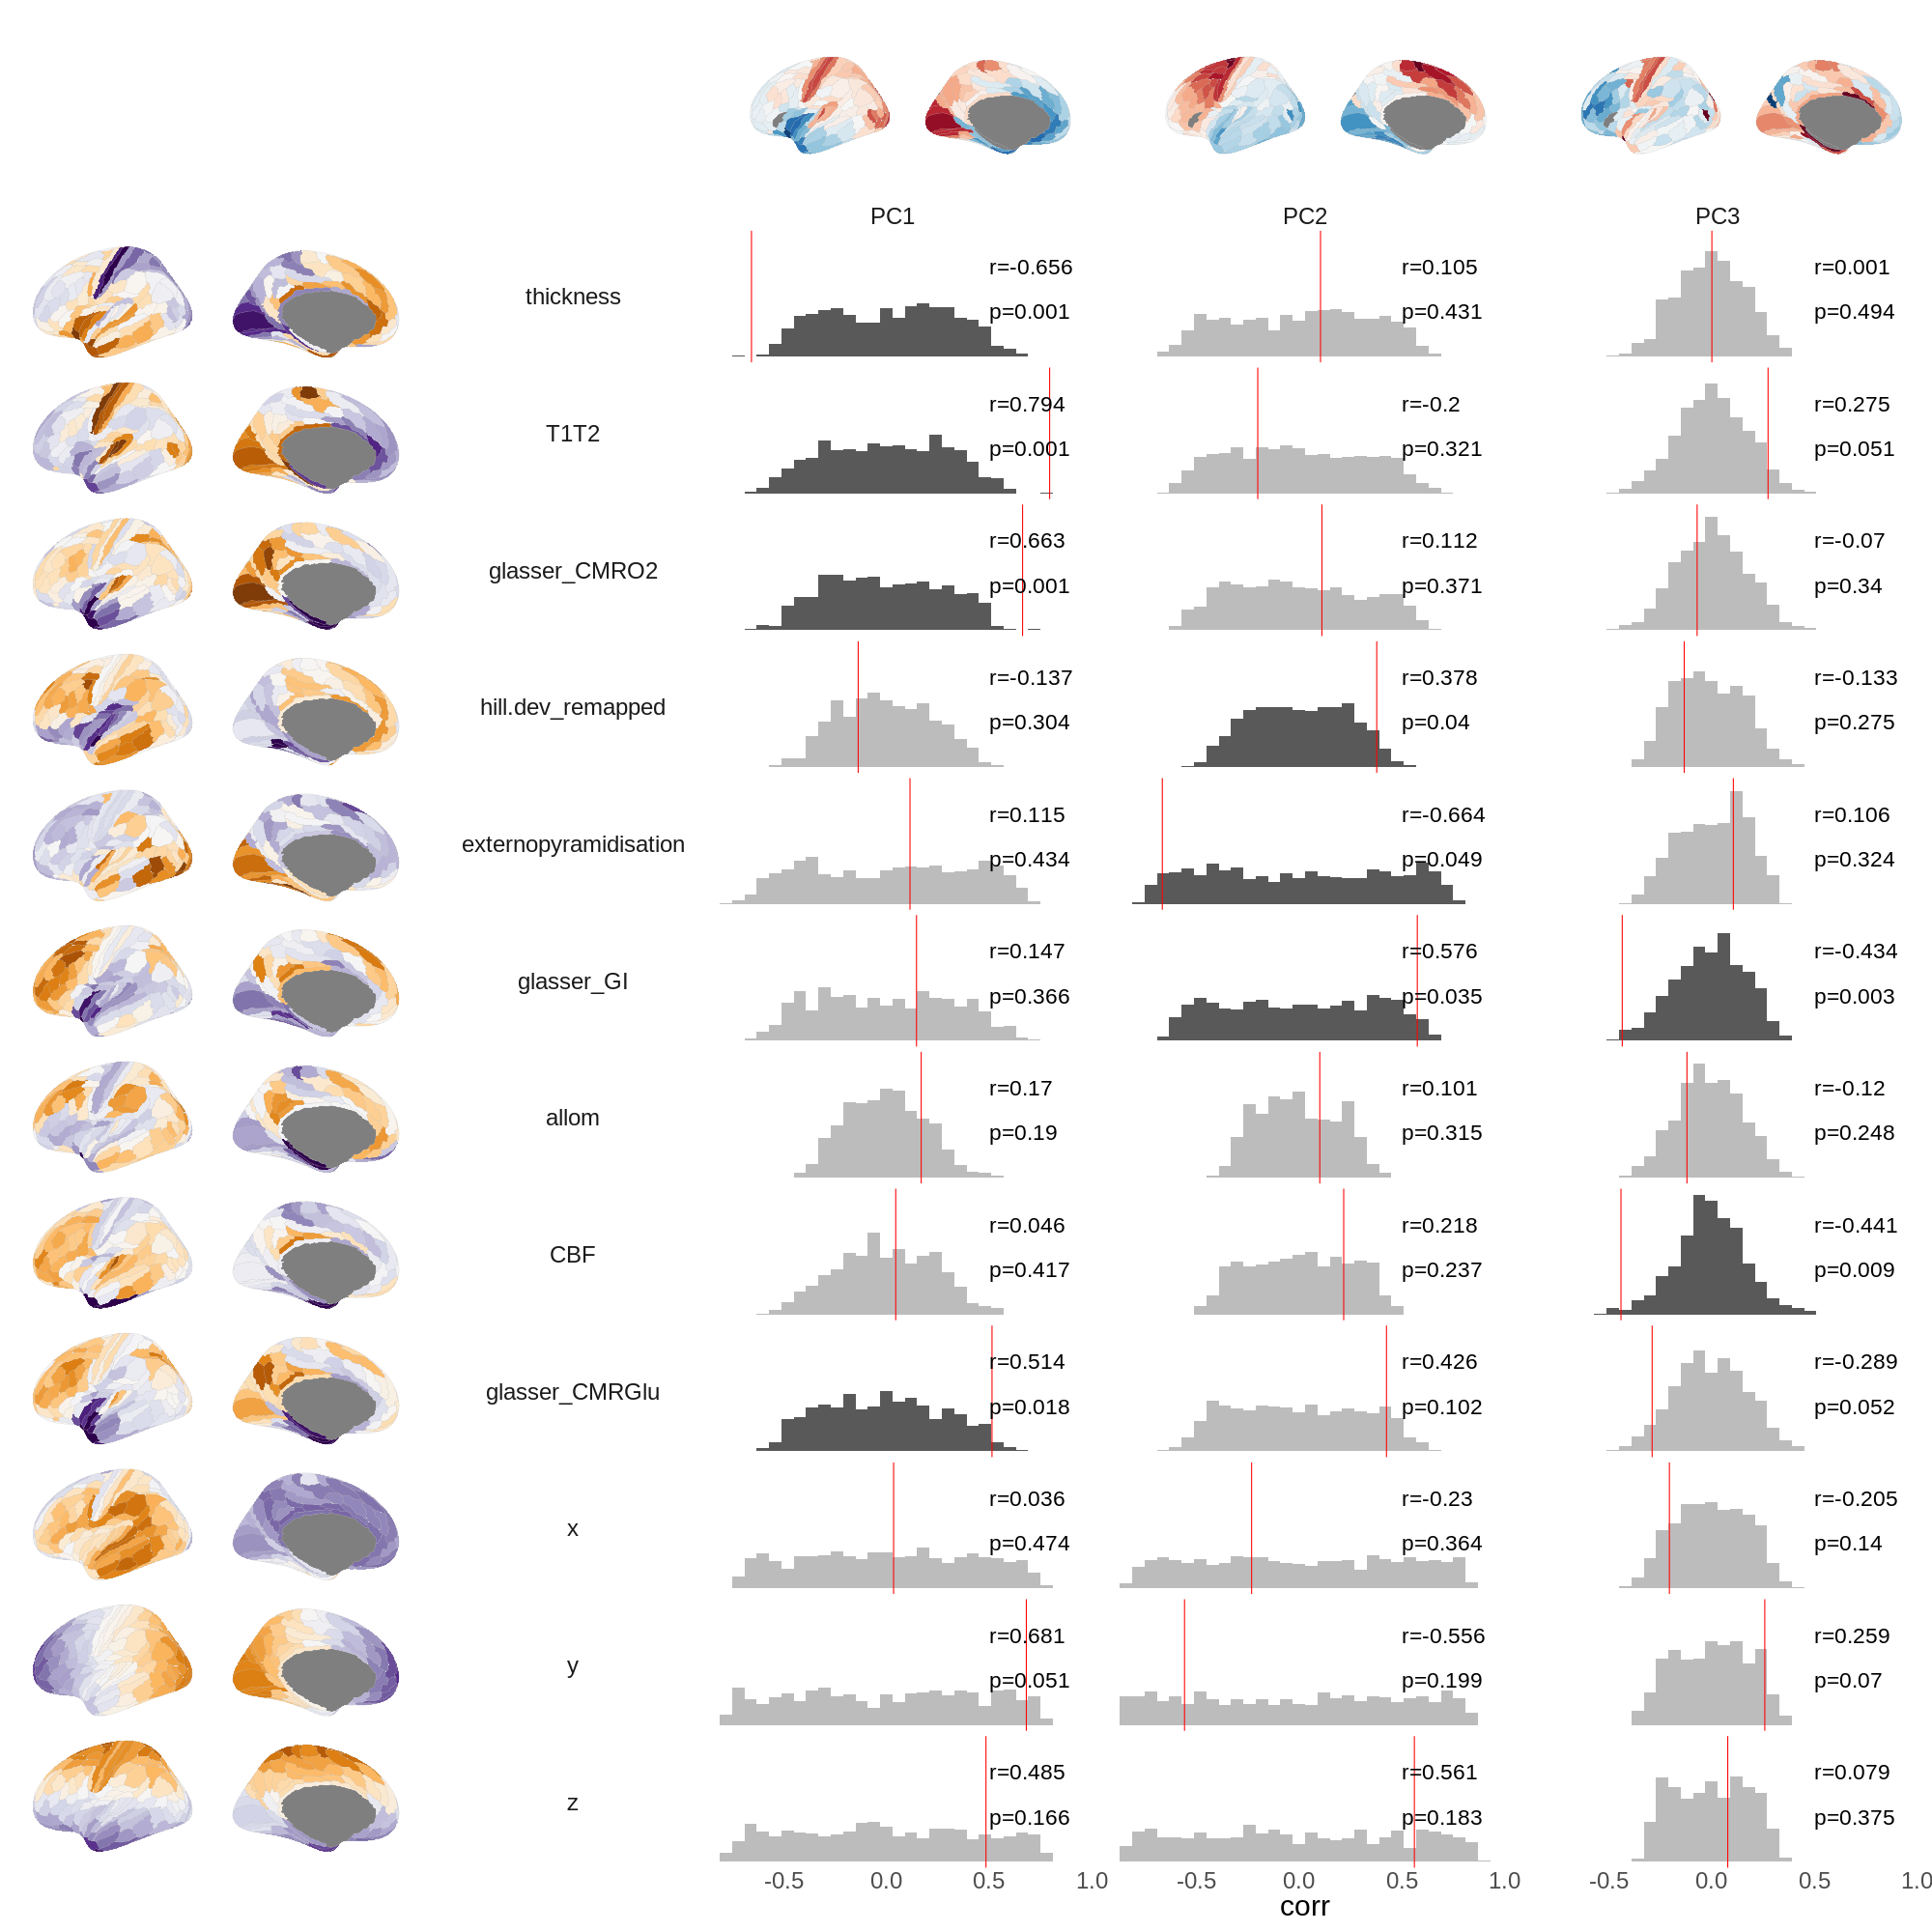

In [360]:
%%R -i corrs -i null_corrs -i null_p -i scores_plot -i maps_order -w 2000 -h 2000
source("../code/plot_maps.R")
g1 <- plot_spin_corrs(corrs, null_corrs, null_p)
g2 <- plot_hcp_wide(scores_plot) + guides(fill='none')
g3 <- plot_maps(maps_order, colors=rev(brewer.puor(100)), ncol=1) + theme(strip.text.x=element_blank()) + guides(fill='none')

(
    ((plot_spacer() | g2) + plot_layout(widths=c(3,5))) / 
    ((g3 | g1) + plot_layout(widths=c(1,3)))
) + plot_layout(heights=c(1,12))

If using all maps

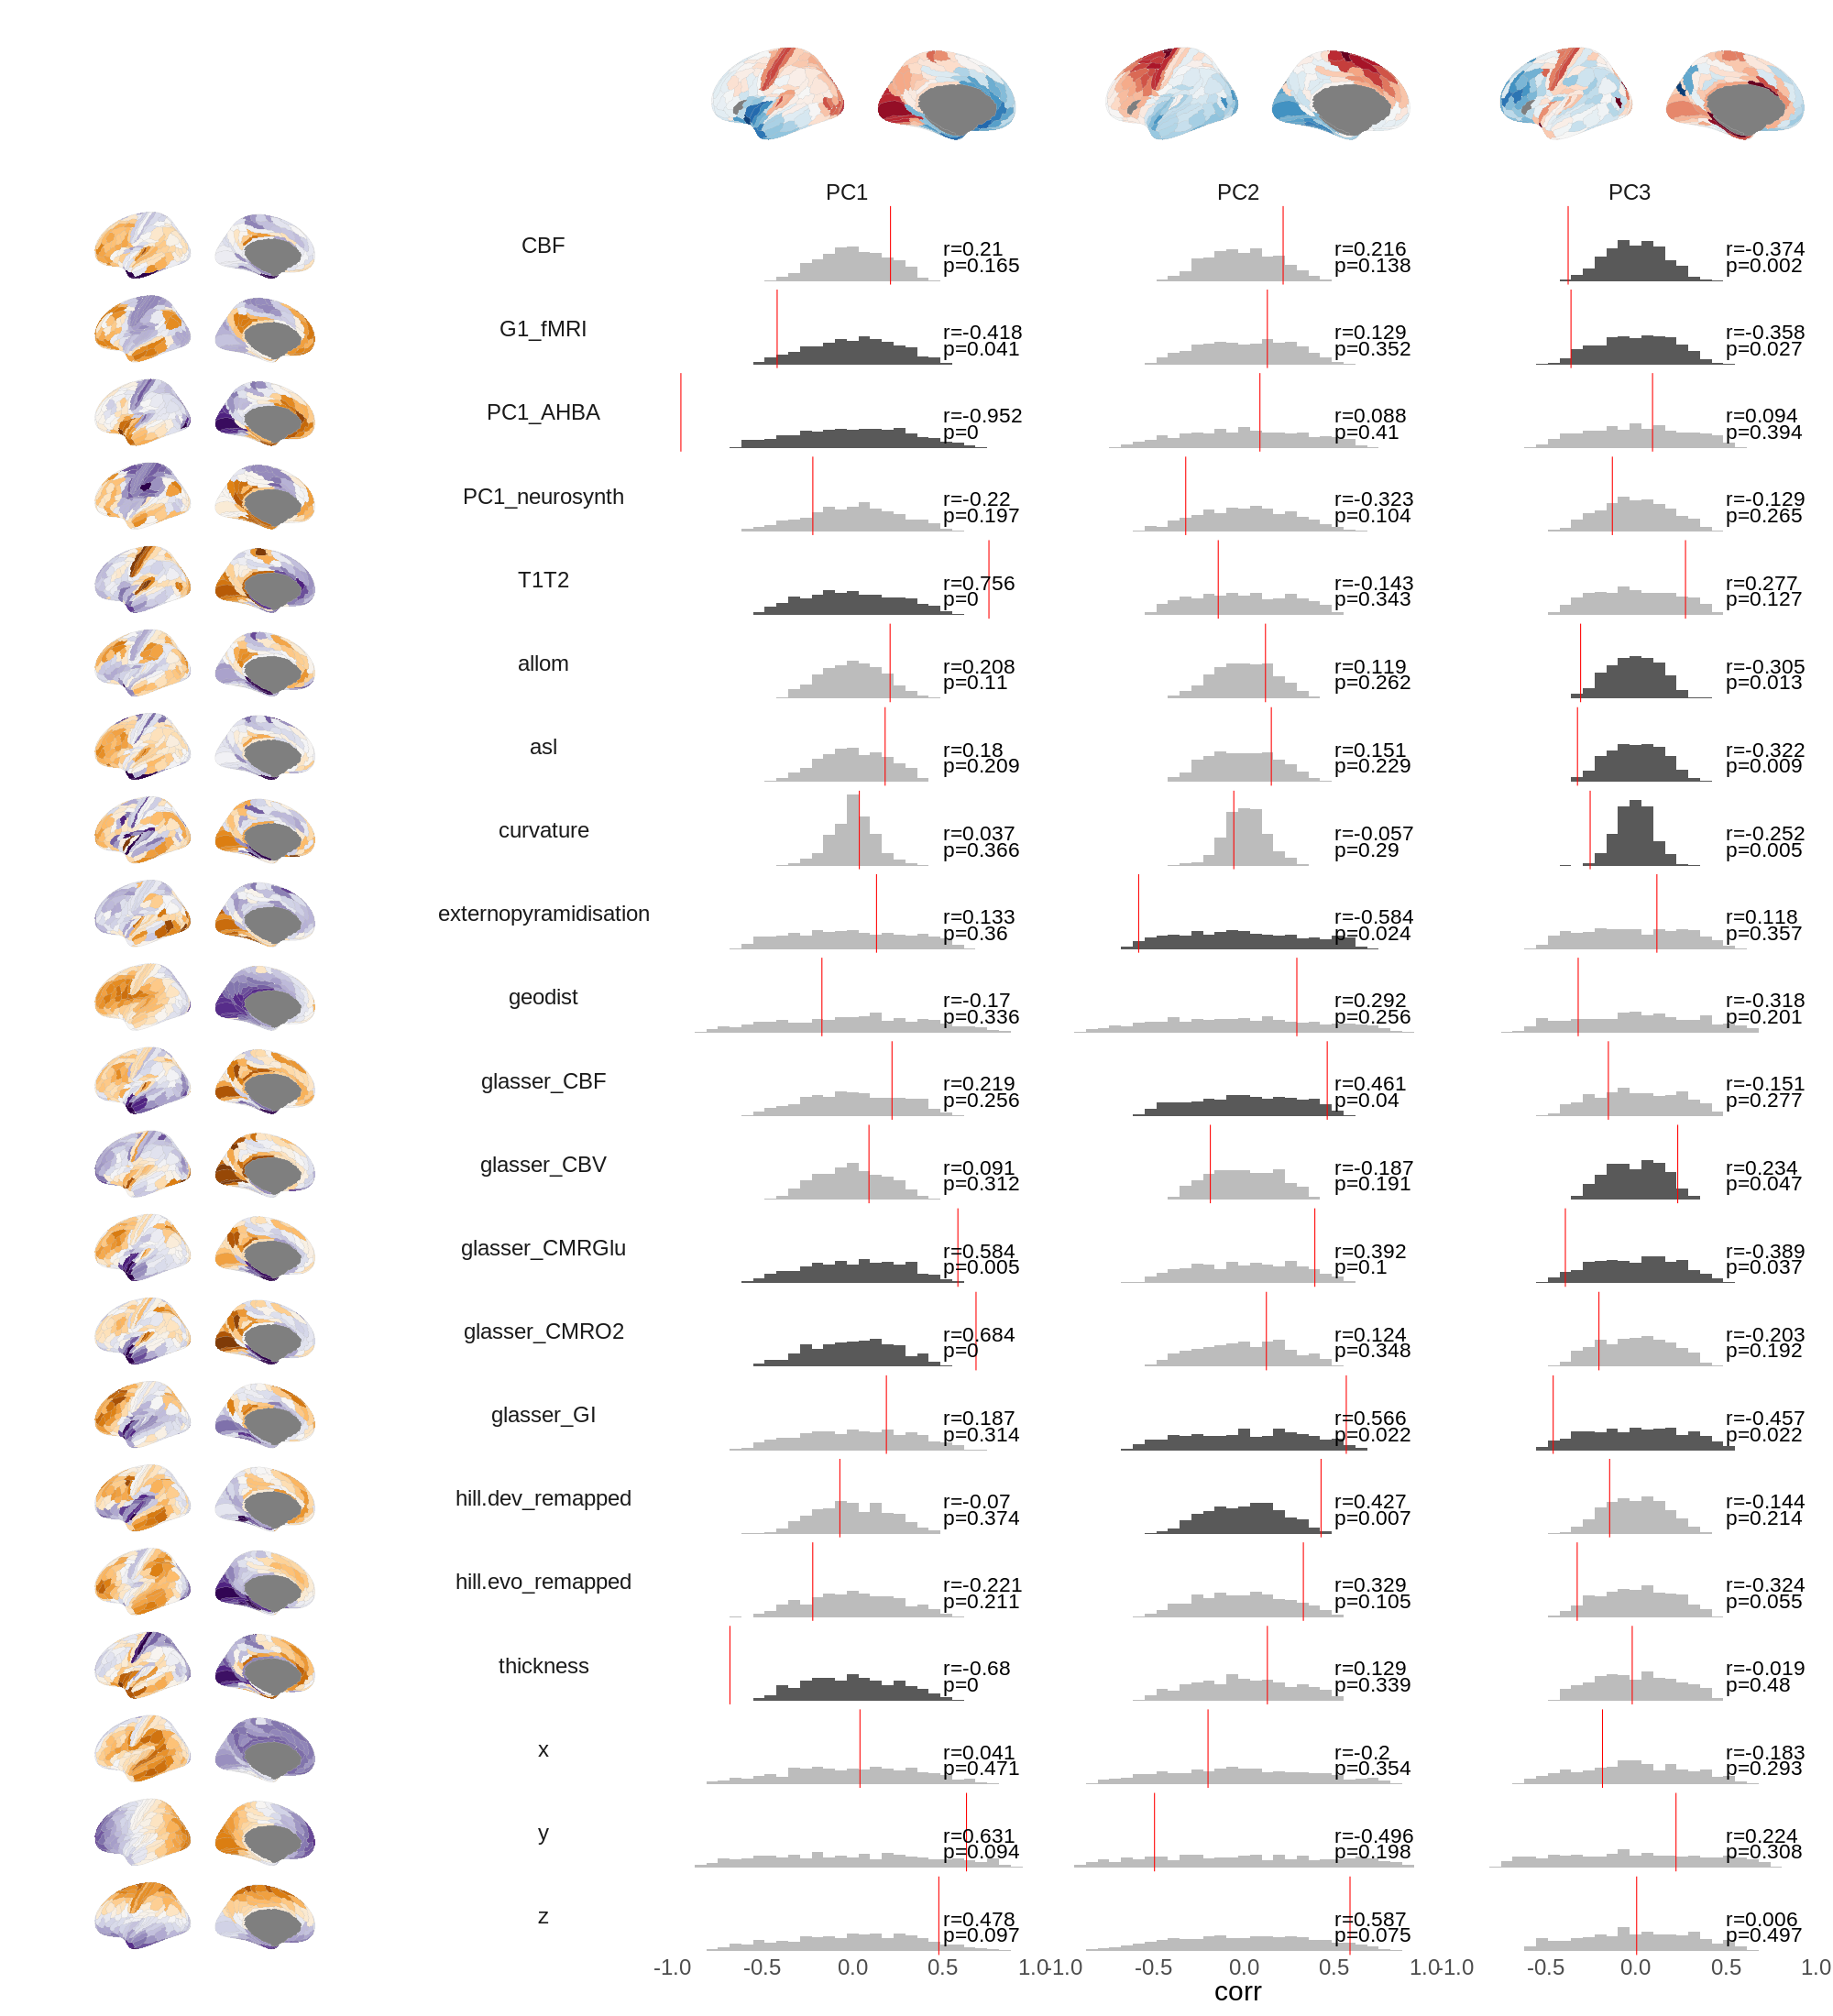

In [223]:
%%R -i corrs -i null_corrs -i null_p -i null_sig -i scores_plot -i maps_order -w 2000 -h 2200
source("../code/plot_maps.R")
g1 <- plot_spin_corrs(corrs, null_corrs, null_p, null_sig)
g2 <- plot_hcp_wide(scores_plot) + guides(fill='none')
g3 <- plot_maps(maps_order, colors=rev(brewer.puor(100)), ncol=1) + theme(strip.text.x=element_blank()) + guides(fill='none')

(
    ((plot_spacer() | g2) + plot_layout(widths=c(3,5))) / 
    ((g3 | g1) + plot_layout(widths=c(1,3)))
) + plot_layout(heights=c(1,15))

Plot spins

In [496]:
null_corrs = null_corrs_dict['spin_maps_pe']
null_maps = spin_maps
# null_corrs = null_corrs_dict['sim_maps_pe']
# null_maps = sim_maps_1000

In [497]:
percentiles = [0,1,5,95,99,100]
pc = 'PC2'
m = 'hill.dev_remapped'
map_ix = list(maps.columns).index(m)

In [498]:
pc_corrs = (null_corrs
            .set_index('map').loc[m]
            .loc[:, pc]
           )
pcen = np.percentile(pc_corrs, q=percentiles)
null_ixs = [abs(pc_corrs - p).argmin() for p in pcen]
null_ixs

[78, 209, 815, 263, 214, 877]

In [499]:
p_c_pairs = zip(percentiles, pc_corrs[null_ixs])
cols = [str(p)+"th, r="+str(round(c,2)) for (p,c) in p_c_pairs]

nulls_to_plot = (
    pd.DataFrame(null_maps[:,map_ix, null_ixs], 
                 index=list(range(1,181)), 
                 columns=cols
                )
    .join(get_labels_hcp())
    .melt(id_vars='label', var_name='version', value_name='score')
    # .assign(version = lambda x: x['version'].astype('str') + 'th')
    # .assign(version = lambda x: 'corr = ' + x['version'].astype('str'))
    .fillna(0)
)

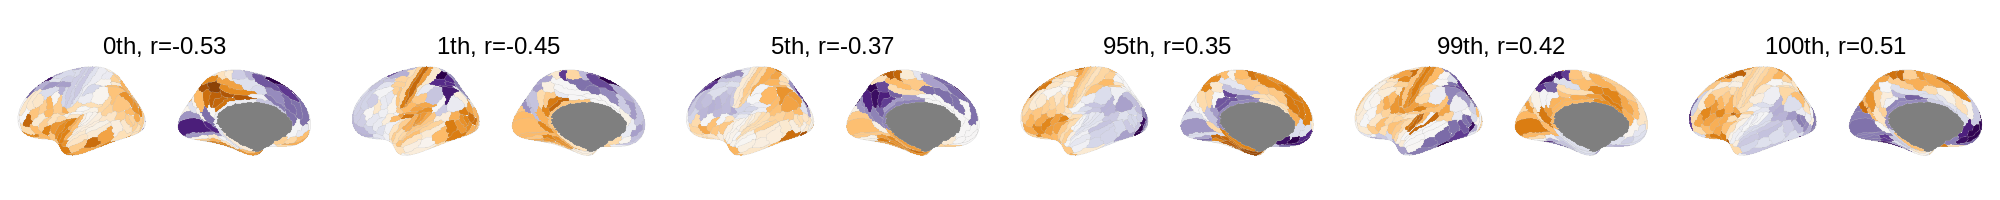

In [500]:
%%R -i nulls_to_plot -w 2000 -h 200
df <- nulls_to_plot %>% 
        mutate(region = recode(label,'7Pl'='7PL')) %>% select(-label) %>%
        mutate_at(vars(version), ~ factor(., levels=unique(.))) %>% 
        group_by(version)

    m <- pmax(
        df %>% .$score %>% quantile(.99) %>% abs,
        df %>% .$score %>% quantile(.01) %>% abs
    )

    glasser$data <- glasser$data %>% filter(hemi=='left')
    
    ggplot(df) + 
    geom_brain(
        atlas=glasser,
        mapping=aes(fill=score, geometry=geometry, hemi=hemi, side=side, type=type),
        colour='grey', size=.1,
        show.legend=T
        ) +
    theme_void() + 
    facet_wrap(~version, ncol=8) +
    theme(legend.position='bottom',
          strip.text.x=element_text(vjust=1),
          strip.text.y.left = element_text(angle = 0),
          plot.title=element_text(hjust=0.5)) +
    scale_fill_gradientn(colors=rev(brewer.puor(100)), 
                         limits=c(-m,m), oob=squish, breaks=c(-m,0,m), 
                         labels=c(round(-m,2),0,round(m,2)), name=''
                        ) +
    guides(fill='none') +
    coord_sf(clip='off') + xlab("") + ylab("") +
    theme(text=element_text(size=30))